# Advanced Data Analytics for Management Support - Submission - Christin Pohl

# Introduction

The task of this assignment is to predict the price of Airbnb listings in London, UK. Therefore, a data set with both  numeric/categorical features as well as text features is given. The text features will be analysed using NLP methods.

First the train and test data is analyzed, the data is cleaned and some features are modified. Second, different modeling approaches are tested. Namely, without textual features, only textual features and all available features. An NLP pipeline is chosen. Finally, the model is applied on the test data.  

## Table of Contents

    1. Package imports
    2. Non-textual Features: Data Exploration, Handling of Missing Values, Data Cleaning 
        2.1 Data Exploration
        2.2 Inspection on missing values
        2.3 Aggregating levels of categorical variables
        2.4 Preprocessing of amenities
        2.5 Adressing Multi-collinearity
    3. Baseline Models on Non-textual Features
        3.1 Linear Regression
        3.2 Random Forest
        3.3 XGB
    4. Cleaning and Preperation on Textual Features
    5. Models on Textual Features
        5.1 LSTM
        5.2 Bidirectional LSTM
    6. Combining models
        6.1 Strategy 1
        6.2 Strategy 2
        6.3 Strategy 3
        6.4 Strategy 4
    7. Application to Test Set
    8. Summary
    9. Appendix - Bert Regression and Results

# 1. Package imports

In [184]:
import matplotlib.pyplot as plt
import missingno as msno
import nltk
import numpy as np
import operator
import pandas as pd
import pickle 
import re
import seaborn as sns
import sklearn
import statsmodels.api as sm
import tensorflow as tf
import tqdm
import torch
import torch.nn as nn
import xgboost as xgb

In [ ]:
from collections import Counter
from IPython.display import Image
from keras.callbacks import EarlyStopping
from keras.initializers import Constant
from keras.layers import *
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from matplotlib import pyplot
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordTokenizer
nltk.download('stopwords')
from pandas_profiling import ProfileReport
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import StandardScaler
from tensorflow.keras import activations, losses
from tqdm import tqdm
from torch.nn.utils.clip_grad import clip_grad_norm_
from torch.utils.data import TensorDataset, DataLoader
from transformers import AdamW
from transformers import BertModel
from transformers import BertTokenizer
from transformers import get_linear_schedule_with_warmup
from xgboost import plot_importance

# 2. Non-textual Data Exploration, Handling of Missing Values, Data Cleaning 

In [223]:
train = pd.read_csv("train.csv", sep = ",", encoding = "utf-8")
test = pd.read_csv("test.csv", sep = ",", encoding = "utf-8")

The columns for both test and train data are the same except for the target column. The data set contains no duplicates in terms of the primary key listing_id. The training set is sufficiently long with 55284 rows to train models.

In [187]:
pd.set_option('display.max_columns', None)
train.head(3)

,name,summary,space,description,experiences_offered,neighborhood_overview,transit,house_rules,picture_url,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,host_total_listings_count,host_has_profile_pic,host_identity_verified,neighbourhood,neighbourhood_cleansed,zipcode,latitude,longitude,property_type,room_type,accommodates,bathrooms,bedrooms,beds,bed_type,amenities,price,guests_included,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,cancellation_policy,reviews_per_month,listing_id
0,Attic Room in historic Greenwich,The room does not have a door but its own disc...,Double room available in historic royal Greenw...,The room does not have a door but its own disc...,business,NaN,Parking is restricted in London. Visitors park...,no shoes on carpets no food in attic room no o...,https://a0.muscache.com/im/pictures/20045164/7...,2167992,2012-04-18,within an hour,100%,t,1.0,t,f,Greenwich,Greenwich,SE10 8SX,51.47457,-0.01062,Townhouse,Private room,2,1.0,1.0,1.0,Pull-out Sofa,"{Wifi,""Paid parking off premises"",Heating,Wash...",35.0,1,95.0,10.0,10.0,10.0,10.0,10.0,10.0,strict_14_with_grace_period,2.37,9Q1RD6H7IO
1,Lovely Garden Studio Private Access,"Garden studio with private entrance, 5 minutes...","Beautiful studio with a king size bed, a sofa ...","Garden studio with private entrance, 5 minutes...",none,Crouch End is a very hip and friendly neighbou...,Walk across the street to the W3 bus stop and ...,We'd love it if you would remove your shoes at...,https://a0.muscache.com/im/pictures/8d1ddcdc-f...,16148175,2014-05-29,within a few hours,100%,t,1.0,t,t,LB of Haringey,Haringey,N8 8NR,51.58329,-0.12416,Guesthouse,Private room,2,1.0,1.0,1.0,Real Bed,"{TV,Wifi,""Free parking on premises"",Breakfast,...",75.0,2,99.0,10.0,10.0,10.0,10.0,10.0,10.0,moderate,2.97,6XDPZPGLSR
2,Comfi apartment 2 close to wimbledon tennis court,NaN,NaN,NaN,none,NaN,NaN,1- No party or event allowed. 2-No smoking ins...,https://a0.muscache.com/im/pictures/e7e4a740-d...,272000199,2019-06-28,within an hour,100%,f,2.0,t,f,LB of Merton,Merton,SW19 1DG,51.41634,-0.18567,Apartment,Entire home/apt,5,1.0,1.0,2.0,Real Bed,"{Wifi,Kitchen,""Paid parking off premises"",Heat...",120.0,2,84.0,9.0,9.0,10.0,10.0,9.0,8.0,strict_14_with_grace_period,1.73,SND9OPN6IY


## First data exploration

Please note the data exploration part has been truncated as the Notebook is already quite long and data exploration insights will be similar across different submissions most probably. Data exploration that is necessary for the task at hand is included.

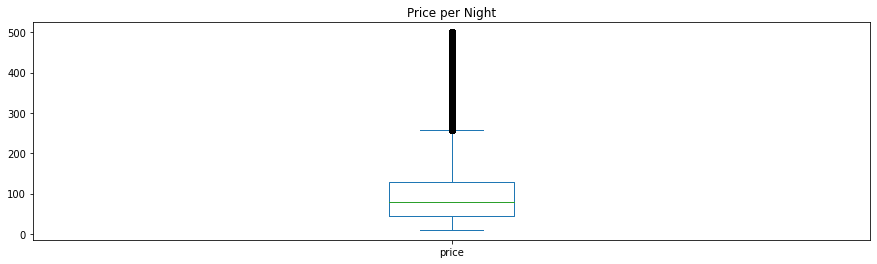

In [188]:
plt.subplots(figsize=(15, 4))
plt.title("Price per Night")
train.price.plot.box();

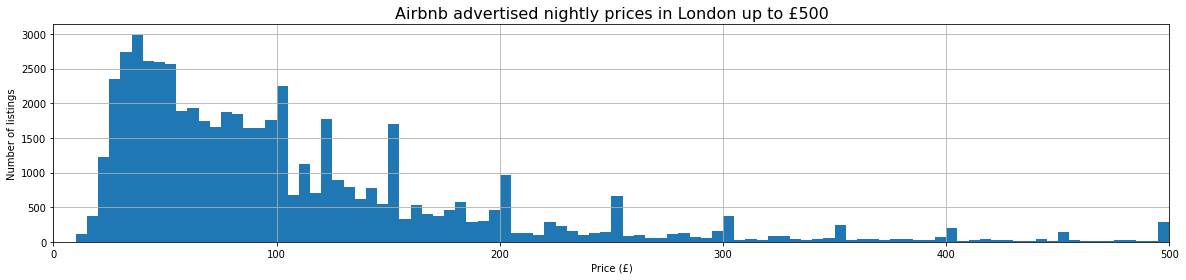

In [189]:
# Distribution of prices from £0 to £500
plt.figure(figsize=(20,4))
train.price.hist(bins=100, range=(0,500))
plt.margins(x=0)
plt.title("Airbnb advertised nightly prices in London up to £500", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

There is only a very small number of listings that is priced at more than £500.

As one can see there is a significant different in prices per night in different neighbourhoods. This is a strong indicator that neighbourhood might be an important feature for price prediction.

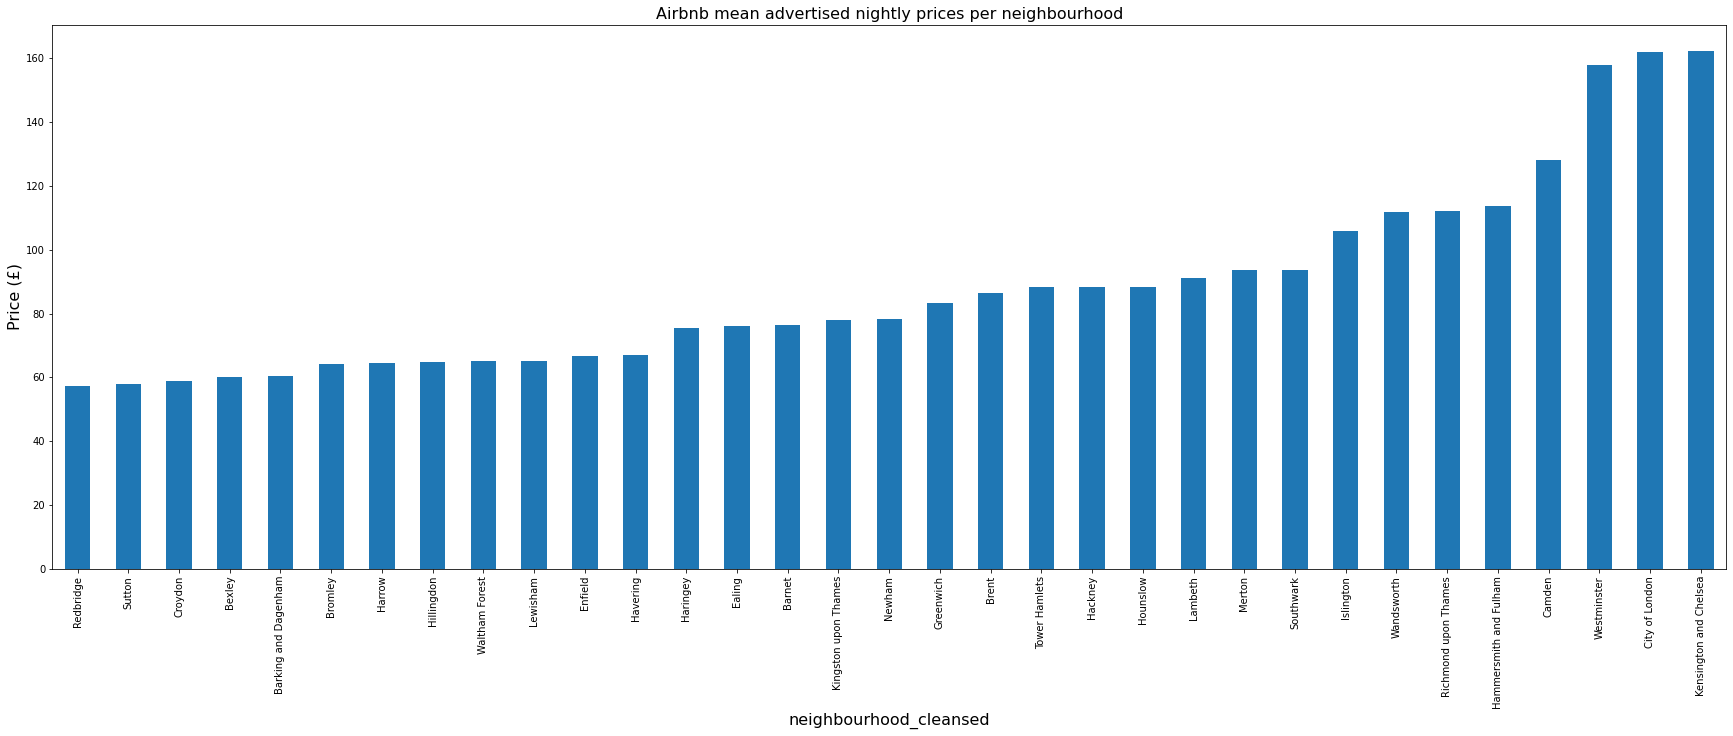

In [238]:
plt.title("Airbnb mean advertised nightly prices per neighbourhood", fontsize=16)
plt.xlabel("Neighbourhood",  fontsize=16)
plt.ylabel("Price (£)",  fontsize=16)
train.groupby("neighbourhood_cleansed")["price"].agg("mean").sort_values().plot.bar(figsize=(30,10));

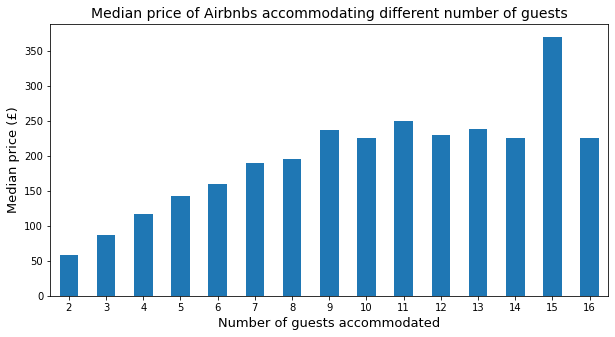

In [191]:
plt.figure(figsize=(10,5))
train.groupby('accommodates').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accommodating different number of guests', fontsize=14)
plt.xlabel('Number of guests accommodated', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.xlim(left=0.5)
plt.show()

As expected when the number of guests rises the mean price per night rises as well. However, interestingly there is a certain plateau from 9 guest onwords except for an outlier at 15 guests.

Inspired by the example submission from last semester the most frequent words within the name for the different listings were analyzed with some interesting results.

## Most Used Words
First the 5% of listings with the highest price is considered.

In [241]:
topfiveperc_value = np.percentile(train.price,95,interpolation = "higher")
topfiveperc_ix = train.index[np.where(train.price>topfiveperc_value)]

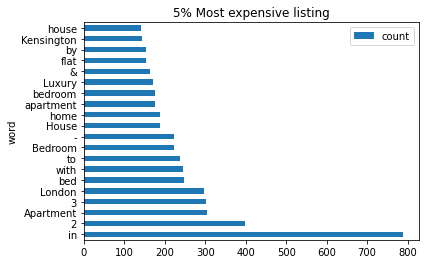

In [242]:
splitted = train.name[topfiveperc_ix].apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for voc in splitted:
    for word, count in voc:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="5% Most expensive listing");

Comparing this with the word count distribution of the name feature of all listings:

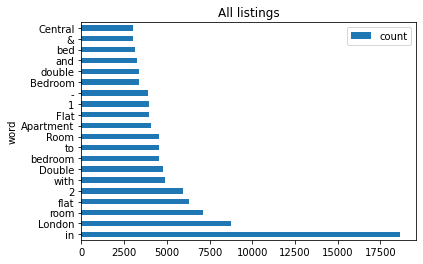

In [244]:
splitted = train.name.astype(str).apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for voc in splitted:
    for word, count in voc:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="All listings");

Finally a comparison with the word usage of the 5% cheapest listings:

In [245]:
bottomfiveperc_value = np.percentile(train.price,5,interpolation="lower")
bottomfiveperc_ix = train.index[np.where(train.price<=bottomfiveperc_value)]

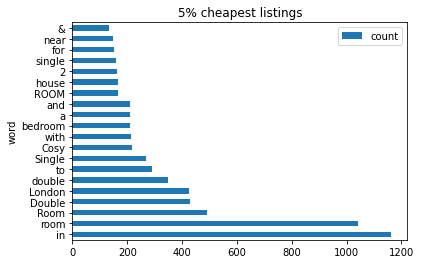

In [247]:
splitted = train.name[bottomfiveperc_ix].astype(str).apply(lambda x: Counter(x.split()).most_common())

wordcounts = {}
for voc in splitted:
    for word, count in voc:
        if word in wordcounts.keys():
            wordcounts[word] += count
        else:
            wordcounts[word] = count
            
counts_df = pd.DataFrame({"word": list(wordcounts.keys()), "count": list(wordcounts.values())})
counts_df.sort_values(by="count",ascending=False)[:20].plot.barh(x="word", title="5% cheapest listings");

As displayed above one can see that for the expensive listings compared to all listings the word luxury is more frequent as well as the word Kensington. 

This aligns with the analysis about the different neighbourhoods were Kensington also has the highest prices. We can see that part of the information present in the textual data is already incorporated in the non-textual features. 

On the otherside, the word cosy is more often used for the least expensive listings. While cosy is still a word with a positive sentiment it thus describes something that might be small. Hence, it is fitting. However, one should keep in mind that a sentiment analysis in this setting makes no sense as hosts try to describe listings in a positive manner.

Please note further data exploration is included within the data preperation part as needed.

## Inspection on missing values

In [197]:
percentage_empty_train = round(train.isnull().mean() * 100,2)
percentage_empty_train.sort_values(ascending=False)

house_rules                    42.29
transit                        35.83
neighborhood_overview          35.28
host_response_time             32.20
host_response_rate             32.20
space                          30.54
review_scores_checkin          24.39
review_scores_value            24.38
review_scores_location         24.38
review_scores_accuracy         24.33
review_scores_communication    24.32
review_scores_cleanliness      24.31
review_scores_rating           24.27
reviews_per_month              22.39
summary                         5.34
description                     3.12
zipcode                         2.30
beds                            0.47
neighbourhood                   0.27
host_has_profile_pic            0.20
host_is_superhost               0.20
host_identity_verified          0.20
host_total_listings_count       0.20
host_since                      0.20
bathrooms                       0.13
bedrooms                        0.11
name                            0.03
p

It becomes visible that many columns do have missing values. The amount of missing values per column is very similar in both testing and training and the columns with missing values are identical. It is good that the target variable price and the listing_id do not have missing values. Because housing rules are missing in 42.29% of the cases the column is deleted from the data set. From a business understanding, housing rules should not affect the price per night significantly.

In [198]:
train.drop('house_rules', axis=1, inplace=True)
test.drop('house_rules', axis=1, inplace=True)

Based on the latitude and longitude data a zip code could be calculated for the City of London. Therefore from a business understanding point of view zip code contains redundant information. As zipcode is a categorical variable it is harder to treat than the continuous variable latitude and longitude. Therefore zipcode is dropped from the dataset.

In [199]:
train.drop('zipcode', axis=1, inplace=True)
test.drop('zipcode', axis=1, inplace=True)

The column host_has_profile_pic is dropped because only 160 hosts do not have a profile picture.

In [200]:
train['host_has_profile_pic'].value_counts()

t    55013
f      160
Name: host_has_profile_pic, dtype: int64

In [201]:
train.drop('host_has_profile_pic', axis=1, inplace=True)
test.drop('host_has_profile_pic', axis=1, inplace=True)

The picture urls are not utilized for the models and therefore droped.

In [202]:
train.drop('picture_url', axis=1, inplace=True)
test.drop('picture_url', axis=1, inplace=True)

Next the missing values are visualized. As one can see from the plot for some parts there exists some clear pattern. When the review_per_month value is missing it seems that all other values for the different review columns are missing as well. This is a clear pattern and needs to be treated with caution as the data is not missing at random. Rather a listing has for a variety of reasons (e.g. new, unpopular) no reviews to calculate the values. To mark for missing values, the review columns will be later on modified to meaningful categories, with one category denoting the nan value. 

Even though the values for the reviews are missing for around 1/3 of each review column. The review columns are not dropped as they might contain super valuable insights. Reviews are very important in people decision to book an Airbnb and hence could influence the price. Additionally, the model should be able to predict prices for new listings without reviews as well.

Another pattern is visible with host_response_time and host_response_rate. This pattern indicates that a host might only have recently registered on Airbnb. It is correlated with the missing review pattern.

<AxesSubplot:>

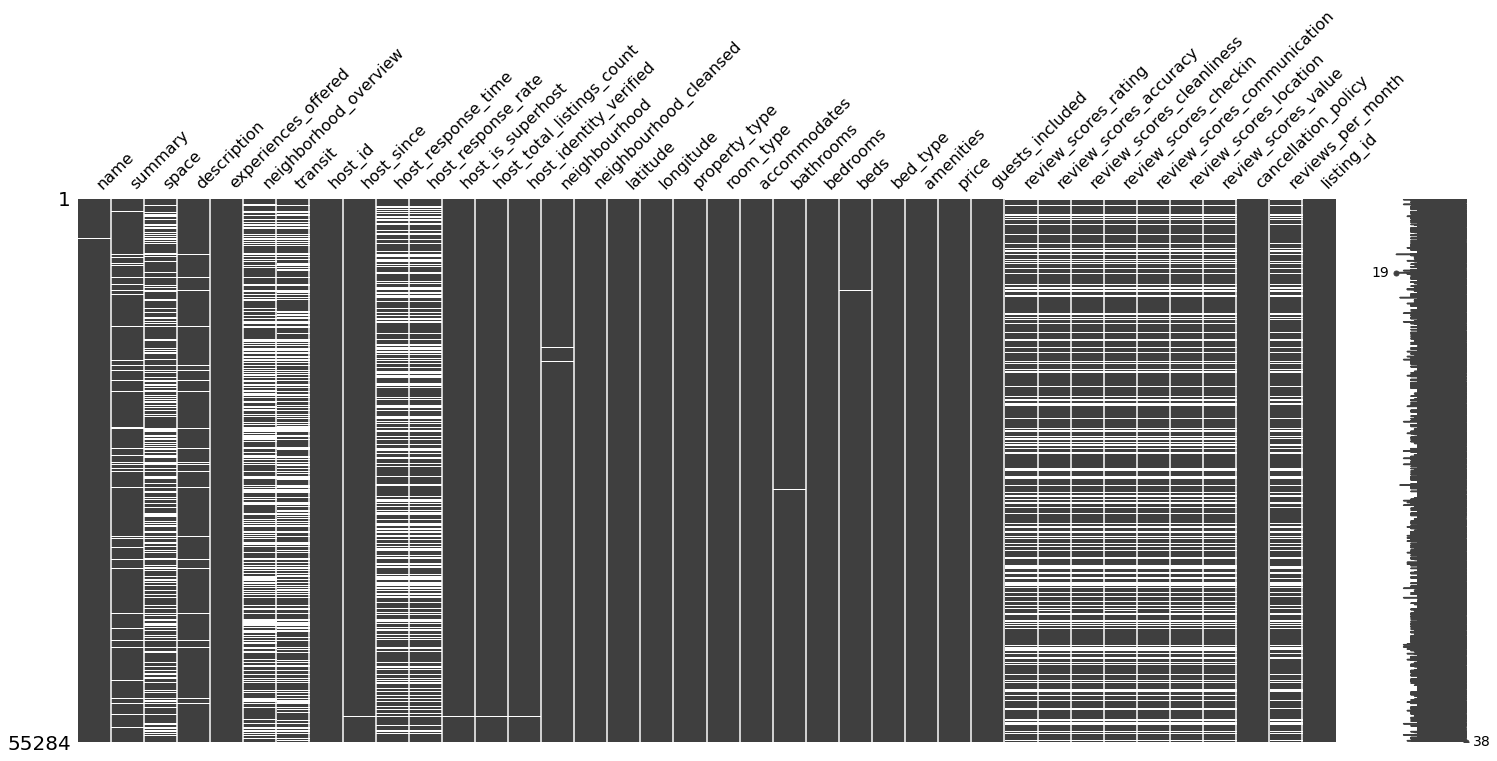

In [203]:
msno.matrix(train)

Additionally, there are a few values missing for the non-textual features beds, host_total_listings_count, host_identity_verified, host_is_superhost, host_since, bathrooms, and bedrooms. 
As this only comprises very few rows. The missing values are replaced with the mean (numerical features) or mode (categorical features) from the training set in both the testing and training sets.

All textual features namely name, summary, space, description, neighborhood_overview and transit contain some missing values. While the amount of missing values varies largely between 0.03% for name and 35.83% for transit. The textual features will be treated later on.

## Aggregating levels of categorical variables
Before dummy coding categorical variables the levels of some categorical variables are aggregated to avoid the curse of dimensionality.

### Reviews
The review variables are categorized to account for missing values. Therefore, a binning mechanism is used to distribute the data into meaningful bins and insert an extra bin for the na values.

In [204]:
ranges = [0,90,95,99,100]
score_labels = ["<=90","90<x<=95","95<x<=99","100"]
train['review_scores_rating'].groupby(pd.cut(train['review_scores_rating'], ranges, labels=score_labels)).count()

review_scores_rating
<=90        12126
90<x<=95     8750
95<x<=99     9313
100         11680
Name: review_scores_rating, dtype: int64

In [205]:
train['review_scores_rating'] = pd.cut(x = train['review_scores_rating'],bins=ranges, labels=score_labels)

test['review_scores_rating'] = pd.cut(x = test['review_scores_rating'],bins=ranges, labels=score_labels)

In [206]:
train['review_scores_rating'] = train['review_scores_rating'].astype('category')
train['review_scores_rating'] = train['review_scores_rating'].cat.add_categories("nan").fillna("nan")

test['review_scores_rating'] = test['review_scores_rating'].astype('category')
test['review_scores_rating'] = test['review_scores_rating'].cat.add_categories("nan").fillna("nan")

In [207]:
train['review_scores_accuracy'] = np.where(train['review_scores_accuracy'] <= 8.0, "8 or below", train['review_scores_accuracy'])
train['review_scores_cleanliness'] = np.where(train['review_scores_cleanliness'] <= 8.0, "8 or below", train['review_scores_cleanliness'])
train['review_scores_communication'] = np.where(train['review_scores_communication'] <= 8.0, "8 or below", train['review_scores_communication'])
train['review_scores_location'] = np.where(train['review_scores_location'] <= 8.0, "8 or below", train['review_scores_location'])
train['review_scores_value'] = np.where(train['review_scores_value'] <= 8.0, "8 or below", train['review_scores_value'])
train['review_scores_checkin'] = np.where(train['review_scores_checkin'] <= 8.0, "8 or below", train['review_scores_checkin'])

In [208]:
train['review_scores_accuracy'].value_counts()

10.0          28315
nan           13448
9.0            9618
8 or below     3903
Name: review_scores_accuracy, dtype: int64

In [209]:
test['review_scores_accuracy'] = np.where(test['review_scores_accuracy'] <= 8.0, "8 or below", test['review_scores_accuracy'])
test['review_scores_cleanliness'] = np.where(test['review_scores_cleanliness'] <= 8.0, "8 or below", test['review_scores_cleanliness'])
test['review_scores_communication'] = np.where(test['review_scores_communication'] <= 8.0, "8 or below", test['review_scores_communication'])
test['review_scores_location'] = np.where(test['review_scores_location'] <= 8.0, "8 or below", test['review_scores_location'])
test['review_scores_value'] = np.where(test['review_scores_value'] <= 8.0, "8 or below", test['review_scores_value'])
test['review_scores_checkin'] = np.where(test['review_scores_checkin'] <= 8.0, "8 or below", test['review_scores_checkin'])

As the values for the review ratings are empty it is assumed that such a listing gets 0 reviews per month.

In [210]:
train['reviews_per_month'] = train['reviews_per_month'].fillna(0.0)

test['reviews_per_month'] = test['reviews_per_month'].fillna(0.0)

<AxesSubplot:>

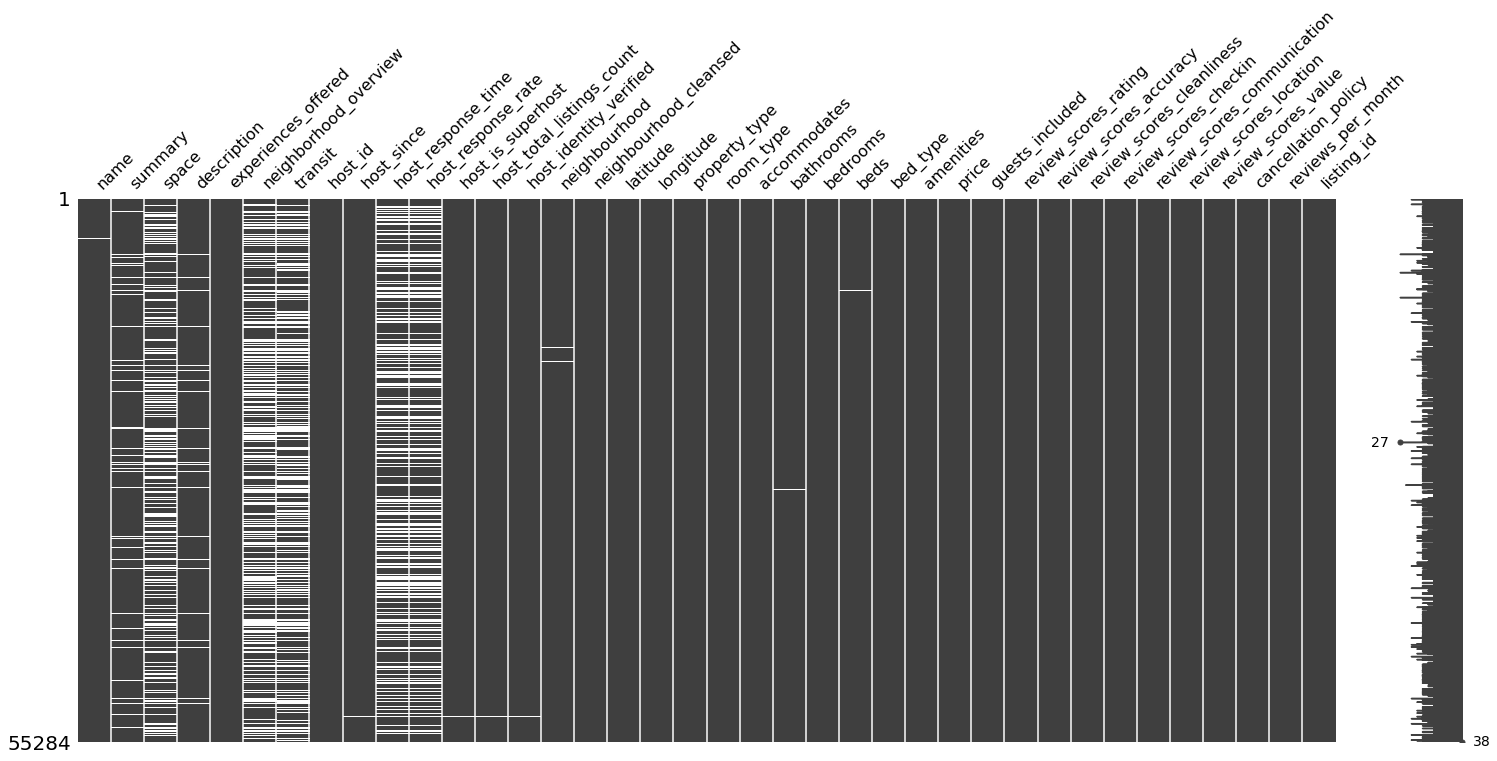

In [211]:
msno.matrix(train)

As shown the missing values for reviews have been filled up successfully.

### Host_response_rate , Host_since, Host_response_time

In [212]:
train["host_response_rate"] = train["host_response_rate"].str.replace("%","")
train = train.astype({"host_response_rate": float})

test["host_response_rate"] = test["host_response_rate"].str.replace("%","")
test = test.astype({"host_response_rate": float})

Get meaningful bins for host_response_rate

In [213]:
ranges = [0,90,99,100]
score_labels = ["<=90","90<x<=99","100"]
train["host_response_rate"].groupby(pd.cut(train["host_response_rate"], ranges, labels=score_labels)).count()

host_response_rate
<=90         6550
90<x<=99     4389
100         25860
Name: host_response_rate, dtype: int64

In [214]:
train['host_response_rate'] = pd.cut(x = train['host_response_rate'],bins = ranges, labels=score_labels)

test['host_response_rate'] = pd.cut(x = test['host_response_rate'],bins = ranges, labels=score_labels)

Host_response_rate add category level nan.

In [215]:
train['host_response_rate'] = train['host_response_rate'].astype('category')
train['host_response_rate'] = train['host_response_rate'].cat.add_categories("nan").fillna("nan")

test['host_response_rate'] = test['host_response_rate'].astype('category')
test['host_response_rate'] = test['host_response_rate'].cat.add_categories("nan").fillna("nan")

Host_response_time add category level nan.

In [218]:
train['host_response_time'] = train['host_response_time'].astype('category')
train['host_response_time'] = train['host_response_time'].cat.add_categories("nan").fillna("nan")

test['host_response_time'] = test['host_response_time'].astype('category')
test['host_response_time'] = test['host_response_time'].cat.add_categories("nan").fillna("nan")

Transform the host_since column to a datetime column which exposes how many years a host has been on Airbnb. 

In [225]:
train['host_since'] = pd.to_datetime(train['host_since'])
train['host_since_years'] = 2022 - train['host_since'].dt.year 
train.drop('host_since', axis=1, inplace=True)

test['host_since'] = pd.to_datetime(test['host_since'])
test['host_since_years'] = 2022 - test['host_since'].dt.year
test.drop('host_since', axis=1, inplace=True)

When there is no value for host_since_years (111 cases) it is filled up with the average

In [226]:
train['host_since_years'] = train['host_since_years'].fillna(train['host_since_years'].median())

test['host_since_years'] = test['host_since_years'].fillna(test['host_since_years'].median())

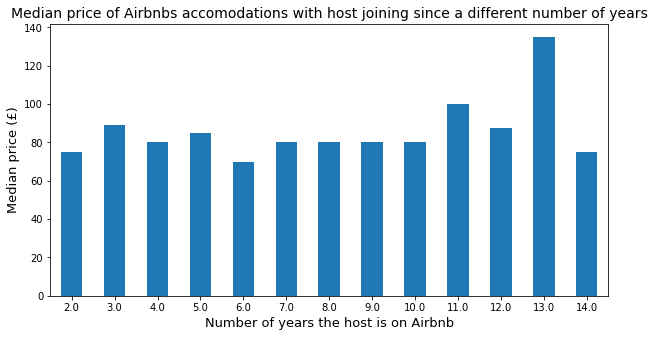

In [235]:
plt.figure(figsize=(10,5))
train.groupby('host_since_years').price.median().plot(kind='bar')
plt.title('Median price of Airbnbs accomodations with host joining since a different number of years', fontsize=14)
plt.xlabel('Number of years the host is on Airbnb', fontsize=13)
plt.ylabel('Median price (£)', fontsize=13)
plt.xticks(rotation=0)
plt.show()

No clear pattern can be detected between how long a host has been on the platform and the price of a listing. This is a hint that hosts adjust the listing prices to the current market prices.

### Filling of nan in host_is_superhost and host_identity_verified with mode


In [122]:
train['host_is_superhost'] = train['host_is_superhost'].fillna(train['host_is_superhost'].mode()[0])
train['host_identity_verified'] = train['host_identity_verified'].fillna(train['host_identity_verified'].mode()[0])

test['host_is_superhost'] = test['host_is_superhost'].fillna(train['host_is_superhost'].mode()[0])
test['host_identity_verified'] = test['host_identity_verified'].fillna(train['host_identity_verified'].mode()[0])

### Filling of nan in host_total_listings_count, beds, bedrooms, bathrooms with median

In [123]:
test['host_total_listings_count'] = test['host_total_listings_count'].fillna(train['host_total_listings_count'].median())
test['beds'] = test['beds'].fillna(train['beds'].median())
test['bedrooms'] = test['bedrooms'].fillna(train['bedrooms'].median())
test['bathrooms'] = test['bathrooms'].fillna(train['bathrooms'].median(),)

train['host_total_listings_count'] = train['host_total_listings_count'].fillna(train['host_total_listings_count'].median())
train['beds'] = train['beds'].fillna(train['beds'].median(),)
train['bedrooms'] = train['bedrooms'].fillna(train['bedrooms'].median())
train['bathrooms'] = train['bathrooms'].fillna(train['bathrooms'].median())

<AxesSubplot:>

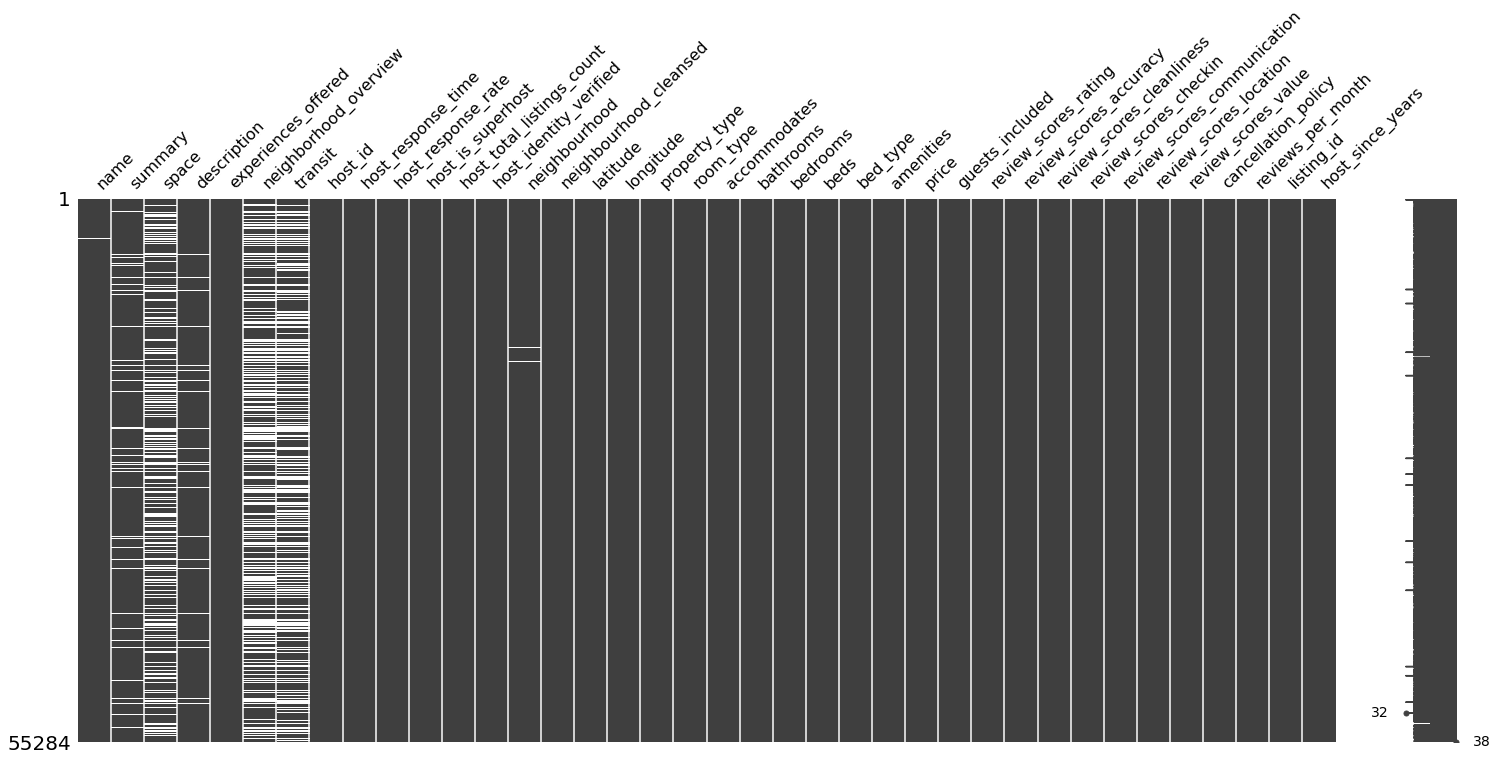

In [124]:
msno.matrix(train)

### Inspect both neighbourhood and neighbourhood_cleansed as well as property_type, bed_type and cancellation_policy

In [125]:
train['neighbourhood']

0             Greenwich
1        LB of Haringey
2          LB of Merton
3               Clapham
4         LB of Lambeth
              ...      
55279         Stockwell
55280      LB of Newham
55281    LB of Haringey
55282     LB of Hackney
55283    LB of Hounslow
Name: neighbourhood, Length: 55284, dtype: object

In [126]:
train['neighbourhood'].nunique()

149

In [127]:
train['neighbourhood_cleansed']

0        Greenwich
1         Haringey
2           Merton
3          Lambeth
4          Lambeth
           ...    
55279      Lambeth
55280       Newham
55281     Haringey
55282      Hackney
55283     Hounslow
Name: neighbourhood_cleansed, Length: 55284, dtype: object

In [128]:
train['neighbourhood_cleansed'].nunique()

33

As neighbourhood_cleansed contains the same information but in a more sorted way with fewer values, the feature is kept and the neighbourhood column is deleted.

In [129]:
train.drop('neighbourhood', axis=1, inplace=True)

test.drop('neighbourhood', axis=1, inplace=True)

In [130]:
train['neighbourhood_cleansed'].value_counts()

Westminster               6011
Tower Hamlets             5434
Hackney                   4135
Camden                    3935
Kensington and Chelsea    3696
Islington                 3284
Lambeth                   3223
Southwark                 3196
Wandsworth                2761
Hammersmith and Fulham    2656
Brent                     1645
Lewisham                  1490
Haringey                  1417
Newham                    1346
Ealing                    1168
Greenwich                 1129
Barnet                    1103
Waltham Forest             998
Merton                     858
Richmond upon Thames       782
Croydon                    741
Hounslow                   720
Redbridge                  479
Enfield                    472
Bromley                    457
Hillingdon                 413
Kingston upon Thames       362
City of London             297
Harrow                     291
Barking and Dagenham       251
Sutton                     196
Havering                   178
Bexley  

A total of 33 neighbourhoods are in the dataset. To avoid the curse of dimensionality the dimensions of the feature neighbourhood_cleansed needs to be reduced. The goal is to keep most of the information while limiting the number of categories. 

The method below reduces the dimensions of the categorical feature. It keeps the neighbourhood for 70% of the data (the most common neighbourhoods) while the remaining 30% of data will be grouped into the category 'Other' (neighboorhood). 

The code of the method cumulatively_categorise can be found under https://towardsdatascience.com/dealing-with-features-that-have-high-cardinality-1c9212d7ff1b. 

One could have used a more advanced approach such as Anova tests (returns whether a feature is significant for the target) which is highley likely from a business understanding point of view or Multiple Correspondence Analysis (MCA) but for simplicity reasons a simpler approach has been adopted.

In [131]:
def cumulatively_categorise(column,threshold=0.7,return_categories_list=True):
    #Find the threshold value using the percentage and number of instances in the column
    threshold_value = int(threshold*len(column))
    #Initialise an empty list for our new minimised categories
    categories_list = []
    #Initialise a variable to calculate the sum of frequencies
    s = 0
    #Create a counter dictionary of the form unique_value: frequency
    counts=Counter(column)

    #Loop through the category name and its corresponding frequency after sorting the categories by descending order of frequency
    for i,j in counts.most_common():
        #Add the frequency to the global sum
        s += dict(counts)[i]
        #Append the category name to the list
        categories_list.append(i)
        #Check if the global sum has reached the threshold value, if so break the loop
        if s >= threshold_value:
            break
    #Append the category Other to the list
    categories_list.append('Other')

    #Replace all instances not in our new categories by Other  
    new_column = column.apply(lambda x: x if x in categories_list else 'Other')
    return new_column,categories_list
  

In [132]:
#Call the function with a default threshold of 70%
train['neighbourhood_cleansed'],new_category_list_train = cumulatively_categorise(train['neighbourhood_cleansed'],return_categories_list=True)

test['neighbourhood_cleansed'],new_category_list_test = cumulatively_categorise(test['neighbourhood_cleansed'],return_categories_list=True)

The method reduces the variable to a total of 12 categories

In [133]:
train['neighbourhood_cleansed'].value_counts()

Other                     15308
Westminster                6011
Tower Hamlets              5434
Hackney                    4135
Camden                     3935
Kensington and Chelsea     3696
Islington                  3284
Lambeth                    3223
Southwark                  3196
Wandsworth                 2761
Hammersmith and Fulham     2656
Brent                      1645
Name: neighbourhood_cleansed, dtype: int64

Apply same procedure to property type and bed type.

In [134]:
train['property_type'],new_category_list_train = cumulatively_categorise(train['property_type'],return_categories_list=True)

test['property_type'],new_category_list_test = cumulatively_categorise(test['property_type'],return_categories_list=True)

In [135]:
new_category_list_train

['Apartment', 'House', 'Other']

In [136]:
train['bed_type'],new_category_list_train = cumulatively_categorise(train['bed_type'],return_categories_list=True)

test['bed_type'],new_category_list_test = cumulatively_categorise(test['bed_type'],return_categories_list=True)

For the cancellation period the threshold is set to 80% based on business understanding to keep the three by far most used categories.

In [137]:
train['cancellation_policy'].value_counts()

strict_14_with_grace_period    24102
flexible                       17094
moderate                       13643
super_strict_60                  230
super_strict_30                  211
strict                             2
luxury_moderate                    1
luxury_super_strict_95             1
Name: cancellation_policy, dtype: int64

In [ ]:
train['cancellation_policy'],new_category_list = cumulatively_categorise(train['cancellation_policy'],threshold=0.8,return_categories_list=True)

test['cancellation_policy'],new_category_list2 = cumulatively_categorise(test['cancellation_policy'],threshold=0.8,return_categories_list=True)

The category levels for all three variables after preprossing are the same for the train and test data.

Inspect variable experiences_offered and delete it as most listings do not contain information for this feature.

In [139]:
print(train['experiences_offered'].value_counts())
train.drop('experiences_offered', axis=1, inplace=True)

test.drop('experiences_offered', axis=1, inplace=True)

none        54222
business      364
family        300
social        266
romantic      132
Name: experiences_offered, dtype: int64


In [140]:
train.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace = True)

test.rename(columns={'neighbourhood_cleansed': 'neighbourhood'}, inplace = True)

### Dummy code all categorical variables

In [141]:
train = pd.get_dummies(data=train, columns=['host_response_time', 'host_response_rate', 'host_is_superhost', 
                                    'host_identity_verified', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                                    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                                    'review_scores_checkin', 'review_scores_communication',
                                    'review_scores_location', 'review_scores_value', 'cancellation_policy'],drop_first=True)

test = pd.get_dummies(data=test, columns=['host_response_time', 'host_response_rate', 'host_is_superhost', 
                                    'host_identity_verified', 'neighbourhood', 'property_type', 'room_type', 'bed_type', 
                                    'review_scores_rating', 'review_scores_accuracy', 'review_scores_cleanliness', 
                                    'review_scores_checkin', 'review_scores_communication',
                                    'review_scores_location', 'review_scores_value', 'cancellation_policy'],drop_first=True)

<span style="color:green"> **Now all non textual features do not contain any null values**</span>

### Preprocessing of amenities

Amenties is provided as a text field for each listing. The idea is to extract and dummy code the most important amenities.

The way of preprocessing the amenities and the code can be found under https://github.com/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb. It has been adapted to fit this dataset. 

First a set of all amenities is created. As the dataset contains 201 different amenities one should focus on the amenities that might have a significant impact on price.

In [142]:
amenities_list = list(train['amenities'])
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('{', '')
amenities_list_string = amenities_list_string.replace('}', ',')
amenities_list_string = amenities_list_string.replace('"', '')
amenities_set = [x.strip() for x in amenities_list_string.split(',')]
amenities_set = set(amenities_set)
len(amenities_set)

201

The selection of amenities is heuristically by examing which amenities might influence price the most. The amentity should be not to uncommon e.g. 'Stand alone steam shower'. 

In [143]:
train.loc[train['amenities'].str.contains('24-hour check-in'), 'check_in_24h'] = 1
train.loc[train['amenities'].str.contains('Air conditioning|Central air conditioning'), 'air_conditioning'] = 1
train.loc[train['amenities'].str.contains('Amazon Echo|Game console|Netflix|Projector and screen|Smart TV'), 'high_end_electronics'] = 1
train.loc[train['amenities'].str.contains('BBQ grill|Barbecue utensils|Fire pit'), 'bbq'] = 1
train.loc[train['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
train.loc[train['amenities'].str.contains('Beach view|Beachfront|Lake access|Mountain view|Ski-in/Ski-out|Waterfront'), 'nature_and_views'] = 1
train.loc[train['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
train.loc[train['amenities'].str.contains('TV'), 'tv'] = 1
train.loc[train['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
train.loc[train['amenities'].str.contains('Cooking basics|Full kitchen'), 'cooking'] = 1
train.loc[train['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'dishwasher_washer_dryer'] = 1
train.loc[train['amenities'].str.contains('Elevator'), 'elevator'] = 1
train.loc[train['amenities'].str.contains('Exercise equipment|Gym'), 'gym'] = 1
train.loc[train['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
train.loc[train['amenities'].str.contains('parking'), 'parking'] = 1
train.loc[train['amenities'].str.contains('Garden|Garden or backyard|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
train.loc[train['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
train.loc[train['amenities'].str.contains('Hot tub|Jetted tub|hot tub|Pool'), 'hot_tub_sauna_or_pool'] = 1
train.loc[train['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
train.loc[train['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
train.loc[train['amenities'].str.contains('Pets|pet|Cat|Dog'), 'pets_allowed'] = 1
train.loc[train['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
train.loc[train['amenities'].str.contains('Safety card|Security system'), 'secure'] = 1
train.loc[train['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1
train.loc[train['amenities'].str.contains('Smoking allowed'), 'smoking_allowed'] = 1
train.loc[train['amenities'].str.contains('Step-free access|Wheelchair|Accessible'), 'accessible'] = 1
train.loc[train['amenities'].str.contains('Suitable for events'), 'event_suitable'] = 1

Dummy code and drop all amenities which are present in less than 10% (not a solid base for model training) or more than 90% (to frequent to be a key differentiator).

In [145]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = train.iloc[:,70:].columns
train[cols_to_replace_nulls] = train[cols_to_replace_nulls].fillna(0)

# Produces a list of amenity features where one category (true or false) contains fewer than 10% of listings
infrequent_amenities = []
for col in train.iloc[:,70:].columns:
    if train[col].sum() < len(train)/10:
        infrequent_amenities.append(col)
print(infrequent_amenities)

# Dropping infrequent amenity features
train.drop(infrequent_amenities, axis=1, inplace=True)

# Dropping the original amenity feature
train.drop('amenities', axis=1, inplace=True)

['check_in_24h', 'air_conditioning', 'high_end_electronics', 'bbq', 'nature_and_views', 'gym', 'hot_tub_sauna_or_pool', 'secure', 'smoking_allowed', 'accessible', 'event_suitable']


In the end a total of 16 amenities is kept in the data set. 

In [146]:
train.columns[70:]

Index(['balcony', 'breakfast', 'tv', 'coffee_machine', 'cooking',
       'dishwasher_washer_dryer', 'elevator', 'child_friendly', 'parking',
       'outdoor_space', 'host_greeting', 'internet', 'long_term_stays',
       'pets_allowed', 'private_entrance', 'self_check_in'],
      dtype='object')

Now the same procedure is applied on the test set with the insides from the training set.

In [147]:
test.loc[test['amenities'].str.contains('Balcony|Patio'), 'balcony'] = 1
test.loc[test['amenities'].str.contains('Breakfast'), 'breakfast'] = 1
test.loc[test['amenities'].str.contains('TV'), 'tv'] = 1
test.loc[test['amenities'].str.contains('Coffee maker|Espresso machine'), 'coffee_machine'] = 1
test.loc[test['amenities'].str.contains('Cooking basics|Full kitchen'), 'cooking'] = 1
test.loc[test['amenities'].str.contains('Dishwasher|Dryer|Washer'), 'dishwasher_washer_dryer'] = 1
test.loc[test['amenities'].str.contains('Elevator'), 'elevator'] = 1
test.loc[test['amenities'].str.contains('Family/kid friendly|Children|children'), 'child_friendly'] = 1
test.loc[test['amenities'].str.contains('parking'), 'parking'] = 1
test.loc[test['amenities'].str.contains('Garden|Garden or backyard|Outdoor|Sun loungers|Terrace'), 'outdoor_space'] = 1
test.loc[test['amenities'].str.contains('Host greets you'), 'host_greeting'] = 1
test.loc[test['amenities'].str.contains('Internet|Pocket wifi|Wifi'), 'internet'] = 1
test.loc[test['amenities'].str.contains('Long term stays allowed'), 'long_term_stays'] = 1
test.loc[test['amenities'].str.contains('Pets|pet|Cat|Dog'), 'pets_allowed'] = 1
test.loc[test['amenities'].str.contains('Private entrance'), 'private_entrance'] = 1
test.loc[test['amenities'].str.contains('Self check-in'), 'self_check_in'] = 1

In [149]:
# Replacing nulls with zeros for new columns
cols_to_replace_nulls = test.iloc[:,69:].columns
test[cols_to_replace_nulls] = test[cols_to_replace_nulls].fillna(0)

# Dropping the original amenity feature
test.drop('amenities', axis=1, inplace=True)

### Adressing Multi-collinearity 
The code for the multi_collinearity_heatmap can be found under https://github.com/L-Lewis/Airbnb-neural-network-price-prediction/blob/master/Airbnb-price-prediction.ipynb. 

In [151]:
def multi_collinearity_heatmap(df, figsize=(11,9)):
    
    """
    Creates a heatmap of correlations between features in the df. A figure size can optionally be set.
    """
    
    # Set the style of the visualization
    sns.set(style="white")

    # Create a covariance matrix
    corr = df.corr()

    # Generate a mask the size of our covariance matrix
    mask = np.zeros_like(corr, dtype=bool)
    mask[np.triu_indices_from(mask)] = True

    # Set up the matplotlib figure
    f, ax = plt.subplots(figsize=figsize)

    # Generate a custom diverging colormap
    cmap = sns.diverging_palette(220, 10, as_cmap=True)

    # Draw the heatmap with the mask and correct aspect ratio
    sns.heatmap(corr, mask=mask, cmap=cmap, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5}, vmax=corr[corr != 1.0].max().max());

Displaying it without neighbourhoods as there are no significant correlations.

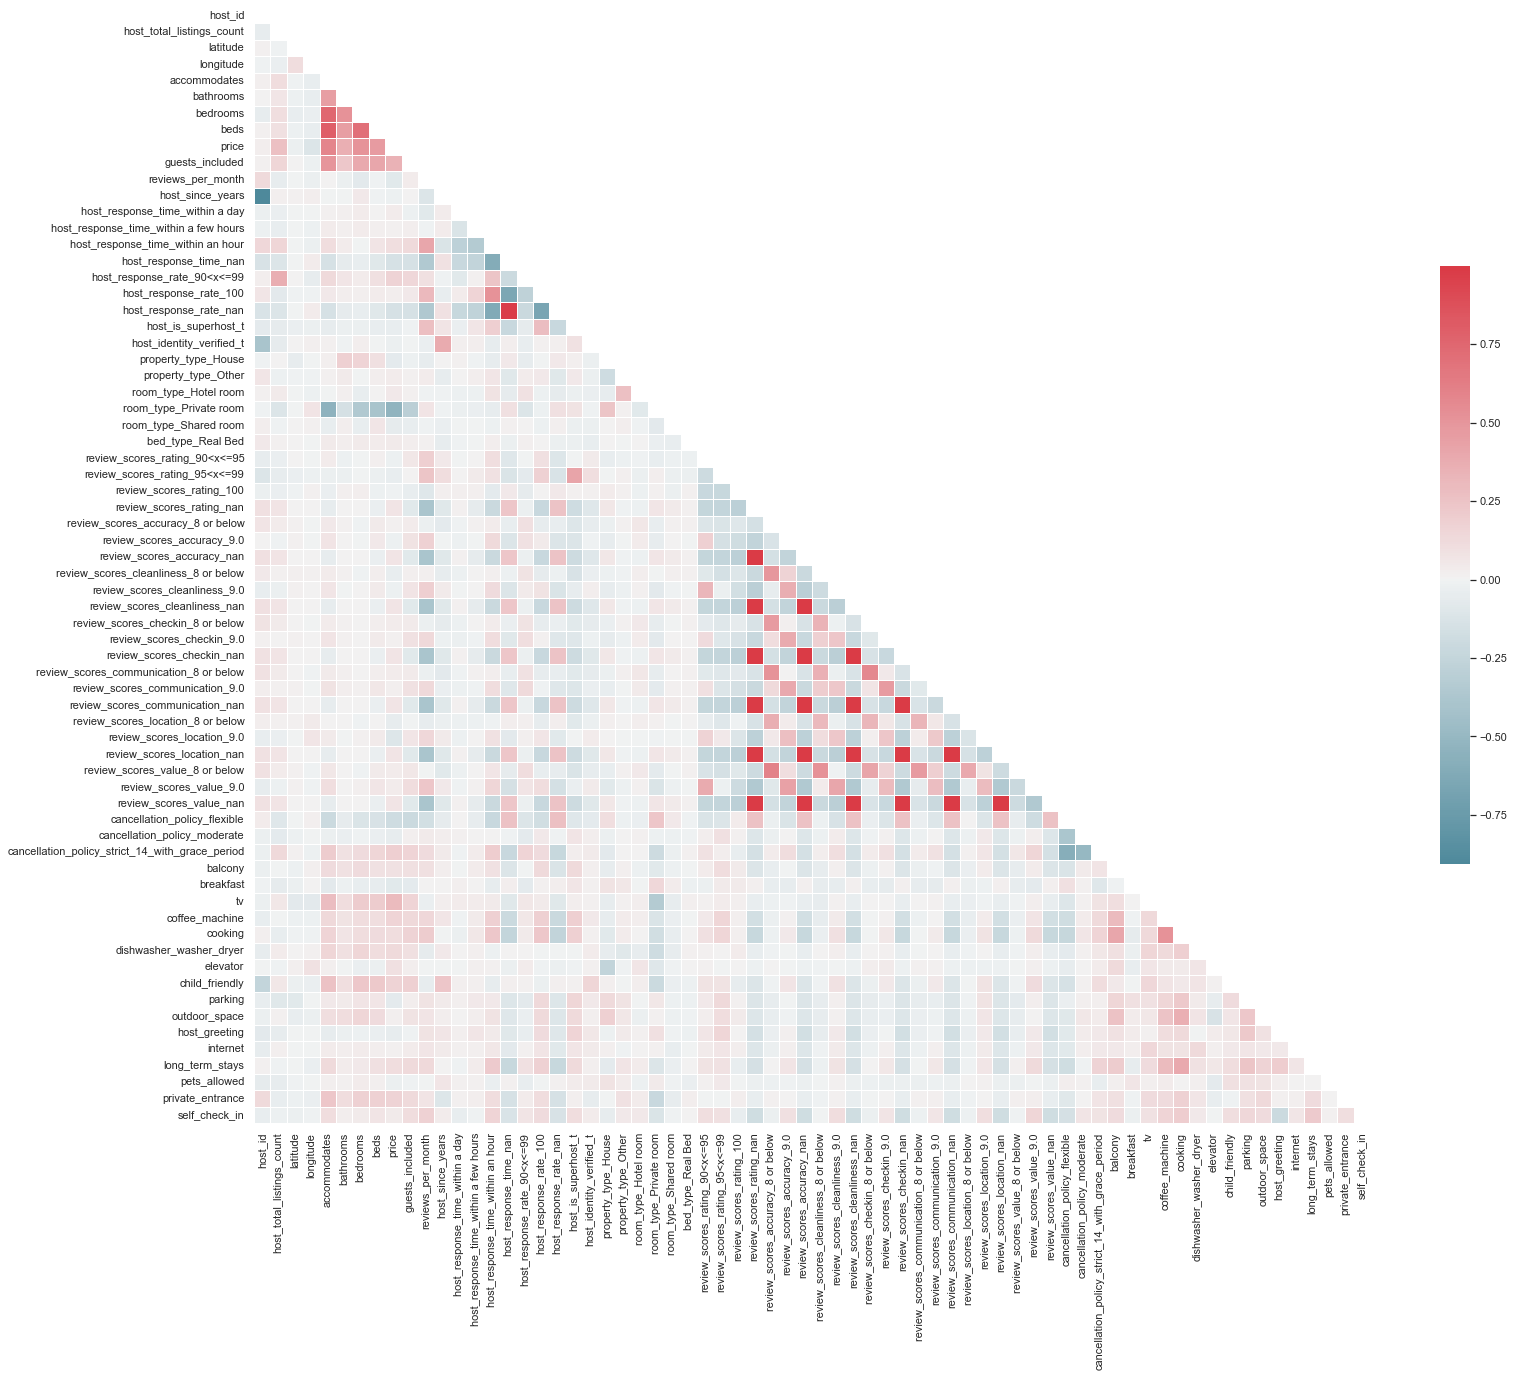

In [152]:
# Final assessment of multi-collinearity
multi_collinearity_heatmap(train.drop(list(train.columns[train.columns.str.startswith('neighbourhood')]), axis=1), figsize=(25,22))

There is perfect correleation betweeen host_response_rate_nan and host_response_time_nan. Hence, one will be droped.

There is near perfect correlation between bedrooms, beds and accomdates. Hence, two columns will be droped. Since accomodates is one of the main search feature that is inserted on Airbnb for every booking request it is kept.

There is a strong negative correlation between host_id and host_since_years. Therefore, host_id will be droped.

Not suprisingly for the rating column there is a near perfect correlation between review_scores_rating_nan and the different review columns with nan values such as review_score_location_nan. Hence, these will be droped as well. 

The review score levels 9.0 or 8.0 and below are after dropping the nan values perfectly correlated as well as the value is either 9.0 or 8.0 and below. The 8.0 and below level can be droped because each rating level (9.0, 8.0 and below, nan) will still have its unique combination due to the review_scores_rating_nan flag. 

In [153]:
train.drop(['host_response_rate_nan', 'bedrooms', 'beds', 'host_id', 'review_scores_accuracy_nan', 'review_scores_cleanliness_nan', 
           'review_scores_communication_nan', 'review_scores_location_nan', 'review_scores_value_nan', 'review_scores_checkin_nan','review_scores_accuracy_8 or below', 'review_scores_cleanliness_8 or below', 
           'review_scores_communication_8 or below', 'review_scores_location_8 or below', 'review_scores_value_8 or below', 'review_scores_checkin_8 or below'], 
          axis=1, inplace=True)

test.drop(['host_response_rate_nan', 'bedrooms', 'beds', 'host_id', 'review_scores_accuracy_nan', 'review_scores_cleanliness_nan', 
           'review_scores_communication_nan', 'review_scores_location_nan', 'review_scores_value_nan', 'review_scores_checkin_nan','review_scores_accuracy_8 or below', 'review_scores_cleanliness_8 or below', 
           'review_scores_communication_8 or below', 'review_scores_location_8 or below', 'review_scores_value_8 or below', 'review_scores_checkin_8 or below'], 
          axis=1, inplace=True)

### Standardization

Depending on the model that is chosen later on standardization might be necessary e.g.LASSO or Ridge regression. However, for tree-based algorithms and gradient boosting it is not necessary. As those algorithms are not sensitive towards the magnitude of variables. The data will be standardized later on depending on each model and how the results change given standardized or not standardized data.

# Data Exploration

# 3. Baseline Models on non-textual features

First building a data set without the textual features.

In [158]:
train_non_textual.drop(['name', 'summary', 'space', 'description', 'neighborhood_overview','transit'], axis=1, inplace=True)

test_non_textual_without_target_variable .drop(['name', 'summary', 'space', 'description', 'neighborhood_overview','transit'], axis=1, inplace=True)

Set the listing_id as index and split the training set further to get a test set which can be evaluated locally.

In [159]:
train_non_textual = train_non_textual.set_index('listing_id')

test_non_textual_without_target_variable = test_non_textual_without_target_variable.set_index('listing_id')

In [160]:
train_non_textual.to_csv('train_non_textual.csv', index = True)

test_non_textual_without_target_variable.to_csv('test_non_textual.csv', index = True)

### Linear Regression

For linear regression, a variety of models and model tuning variations have been tried out to get a sufficient baseline both with sklearn and statsmodels package. The final notebook includes only one linear regression modeling approach for readability reasons.

Things that have been tried out but did not improve or worsened results on both train and "local" test sets are:

1) Standardization and/or Normalization of features because some features do have a screwed distribution (e.g. target variable price, accommodates, etc.) or a large difference in magnitude. (Worse results)

2) Dropping non-significant features and forward/backward selection of features. (No improvement in results)

In [213]:
X_train_non_textual, X_test_non_textual, y_train_non_textual, y_test_non_textual = train_test_split(train_non_textual.loc[: , train_non_textual.columns != 'price'], train_non_textual['price'], test_size=0.3, random_state=42)

In [506]:
regression = make_pipeline(StandardScaler(), LinearRegression())
regression.fit(X_train_non_textual, y_train_non_textual)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('linearregression', LinearRegression())])

In [507]:
prediction = pd.DataFrame({"Prediction": regression.predict(X_test_non_textual), "Actual": y_test_non_textual})

print(f"R2: {regression.score(X_test_non_textual, y_test_non_textual)}")
print(f"RMSE: {mean_squared_error(prediction.Actual, prediction.Prediction, squared=False)}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

R2: 0.5253813914624874
RMSE: 57.855528120133364
MAE: 37.86612400226911


This serves as the baseline for the other models. The results visible hear could be verified via Kaggle for the "real" test set. 
The inital predictions are already quite promising as the RMSE with 57.86 is way lower than the RMSE 84.77 when using an average prediction of the price. This shows that the non-textual features at hand indeed have predictive power.

### Random Forest

For Random Forest a RandomizedSearch Strategy has been used in the first place. Giving hints as to which area to investigate even more. Afterwards the area from the best model is investigated in more detail again using a GridSearch Strategy. The method and code is inspired by this blogpost https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74.

In [510]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [1, 2, 4, 6, 'sqrt', 'log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create random grid
random_grid = {'n_estimators': n_estimators,
               'max_features' : max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000], 'max_features': [1, 2, 4, 6, 'sqrt', 'log2'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [511]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor()
# Random search of parameters, using 2 fold cross validation, 
# Search across the different combinations
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 10, cv = 2, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train_non_textual, y_train_non_textual)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': [1, 2, 4, 6, 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=2)

In [512]:
#Best parameters
rf_random.best_params_

{'n_estimators': 1000,
 'min_samples_split': 2,
 'min_samples_leaf': 2,
 'max_features': 'log2',
 'max_depth': 90,
 'bootstrap': False}

In [513]:
best_random = rf_random.best_estimator_

In [514]:
prediction = pd.DataFrame({"Prediction": best_random.predict(X_test_non_textual), "Actual": y_test_non_textual})

print(f"R2: {regression.score(X_test_non_textual, y_test_non_textual)}")
print(f"RMSE: {mean_squared_error(prediction.Actual, prediction.Prediction, squared=False)}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

R2: 0.5253813914624874
RMSE: 50.38245442876811
MAE: 30.88712166430934


RandomSearch offered a way to get the right direction for the hyperparameters and already offers a significant improvement compared to Linear Regression. Now GridSearch evaluates all possible combinations around the area that has been identified as promising via the RandomSearch strategy.

In [218]:
tuned_parameters = [{'n_estimators': [ 800, 1000, 1200],
                     'max_features': [ 1, 3,'sqrt', 'log2'],
                     'min_samples_split' : [2, 4],
                     'min_samples_leaf': [1, 2, 3], 
                     'max_depth': [80, 90, 100]}]

grid_search = GridSearchCV(
    RandomForestRegressor(random_state=888),
    param_grid = tuned_parameters,
    cv = 2,
    verbose = 1
    )

grid_search.fit(X_train_non_textual, y_train_non_textual) 

Fitting 2 folds for each of 216 candidates, totalling 432 fits


GridSearchCV(cv=2, estimator=RandomForestRegressor(random_state=888),
             param_grid=[{'max_depth': [80, 90, 100],
                          'max_features': [1, 3, 'sqrt', 'log2'],
                          'min_samples_leaf': [1, 2, 3],
                          'min_samples_split': [2, 4],
                          'n_estimators': [800, 1000, 1200]}],
             verbose=1)

In [219]:
grid_search.best_params_

{'max_depth': 80,
 'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1200}

In [220]:
best_grid = grid_search.best_estimator_

In [221]:
prediction = pd.DataFrame({"Prediction": best_grid.predict(X_test_non_textual), "Actual": y_test_non_textual})
print(f"RMSE: {mean_squared_error(prediction.Actual, prediction.Prediction, squared=False)}")
print(f"MAE: {mean_absolute_error(prediction.Actual, prediction.Prediction)}")

RMSE: 48.478439921636486
MAE: 29.601138206957387


The optimized Random Forest is able to outperform the Linear Regression in all measures taken into account.

To complete with models using non-textual data an Xtreme Gradient Boosting model is trained and evaluated.

## XGB

Several XGB models are tried out with hyperparameter tuning. After finding good combinations of hyperparameter the feature importance is taken into account and different optimized models are built with different thresholds on feature importance. Here only the most relevant models are displayed for readibility reasons.

Renaming columns otherwise the XGB package throws an error because of the "<" sign in column names https://stackoverflow.com/questions/48645846/pythons-xgoost-valueerrorfeature-names-may-not-contain-or

In [188]:
X_train_non_textual_XGB = X_train_non_textual

In [189]:
regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train_non_textual_XGB.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train_non_textual.columns.values]

Using a GridSearch for the hyperparameters and fitting 144 candidates in total.

In [ ]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [1000, 1400, 1800, 2200],
           'colsample_bytree': [0.1,0.3, 0.7,1]}
xgbr = xgb.XGBRegressor(seed=20, tree_method='gpu_hist')
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1, cv=2)
clf.fit(X_train_non_textual_XGB, y_train_non_textual)

The best model is evaluated more closely and the hyperparameters are used for further training. As one can see the number of times a feature is used to split the data across all trees varies heavily. 

<AxesSubplot:>

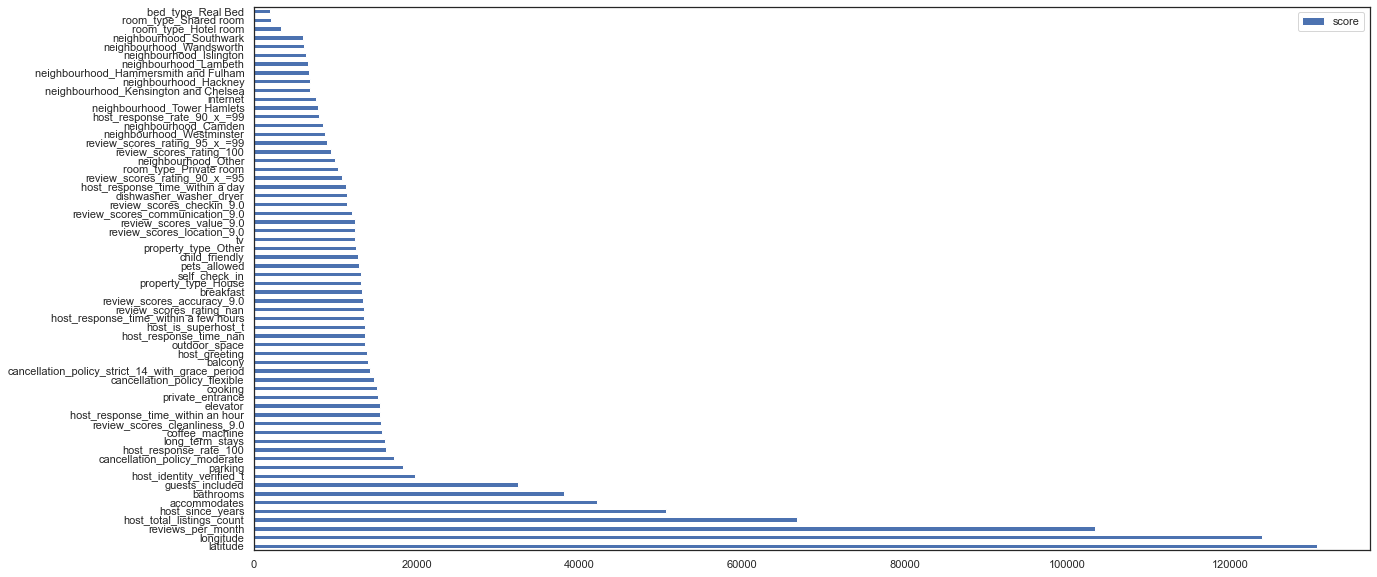

In [192]:
#The number of times a feature is used to to split the data across all trees
feature_important = clf.best_estimator_.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())
data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score")
data.nlargest(len(X_train_non_textual_XGB), columns="score").plot(kind='barh', figsize = (20,10))

Additionally, as one can see below there are a lot of features with very small feature importance. Therefore different thresholds are tested out on how to reduce the data size. A threshold of 0.03 delivers great results as it reduces the number of features drastically to 7 while performing 1 unit better in terms of RMSE than the model taking all features into account. This insight should be later on leveraged when it comes to the combination of textual and non-textual features within models.

In [191]:
clf.best_estimator_.feature_importances_

array([0.01974565, 0.01095856, 0.01152805, 0.0750913 , 0.04600399,
       0.02152669, 0.00758267, 0.0082163 , 0.00562713, 0.00534857,
       0.00882516, 0.01108831, 0.01680771, 0.00616409, 0.00519045,
       0.00562671, 0.01046462, 0.00506   , 0.00687521, 0.00453981,
       0.0369646 , 0.00640268, 0.02513045, 0.00653194, 0.00948928,
       0.00592497, 0.04687137, 0.01463425, 0.00712552, 0.00904984,
       0.25571242, 0.03489146, 0.00430177, 0.00420109, 0.0048444 ,
       0.00712535, 0.01532372, 0.00451904, 0.00513423, 0.00459646,
       0.00420622, 0.01131184, 0.00468053, 0.00961754, 0.00518905,
       0.01210331, 0.00518986, 0.00461911, 0.03415595, 0.01008339,
       0.0068244 , 0.00983643, 0.00963316, 0.01314058, 0.00730551,
       0.00571599, 0.00566707, 0.00834909, 0.00630509, 0.00496047,
       0.01283064, 0.00722897], dtype=float32)

In [193]:
# select features using threshold
selection = SelectFromModel(clf.best_estimator_, threshold=0.03, prefit=True)
select_X_train = selection.transform(X_train_non_textual_XGB)
params = { 'max_depth': [10],
           'learning_rate': [0.01],
           'n_estimators': [2200],
           'colsample_bytree': [0.3]}
# train model
selection_model = xgb.XGBRegressor(seed = 20, tree_method='gpu_hist')
selection_model_cv = GridSearchCV(estimator=selection_model, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=2, cv=10)
selection_model_cv.fit(select_X_train, y_train_non_textual)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

C:\Users\Anaconda3\envs\Adams\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but SelectFromModel was fitted without feature names
  warnings.warn(


Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   8.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   7.8s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   7.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   7.6s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   8.4s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   8.2s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   8.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   8.0s
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time=   8.1s
[CV] END col

Selected features:

In [194]:
feature_idx = selection.get_support()
X_train_non_textual_XGB.columns[feature_idx]

Index(['accommodates', 'bathrooms', 'neighbourhood_Kensington and Chelsea',
       'neighbourhood_Westminster', 'room_type_Private room',
       'room_type_Shared room', 'tv'],
      dtype='object')

Best XGB without reduction of parameters performs slightly worse.

In [315]:
params = { 'max_depth': [6],
           'learning_rate': [0.05],
           'n_estimators': [2000],
           'colsample_bytree': [0.3]}
xgbr = xgb.XGBRegressor(seed = 20, tree_method='gpu_hist')
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=2, cv=10)
clf.fit(X_train_non_textual_XGB, y_traiwn_non_textual)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 10 folds for each of 1 candidates, totalling 10 fits
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  23.2s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  23.4s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  23.3s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  23.6s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  24.1s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  23.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  23.9s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  24.0s
[CV] END colsample_bytree=0.3, learning_rate=0.05, max_depth=6, n_estimators=3000; total time=  23.7s
[CV] END colsample_by

# 4. Cleaning and Preperation of Textual Features

There are six textual features. From a business understanding point of view, the name, as well as the summary and description, are most important. Furthermore, there is a feature space that describes the room layout in more detail and a feature transit that covers transportation information. The feature housing rule has been omitted earlier already.

In [9]:
train_textual = train[['name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'listing_id', 'price']]

test_textual = test[['name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'listing_id']]

<AxesSubplot:>

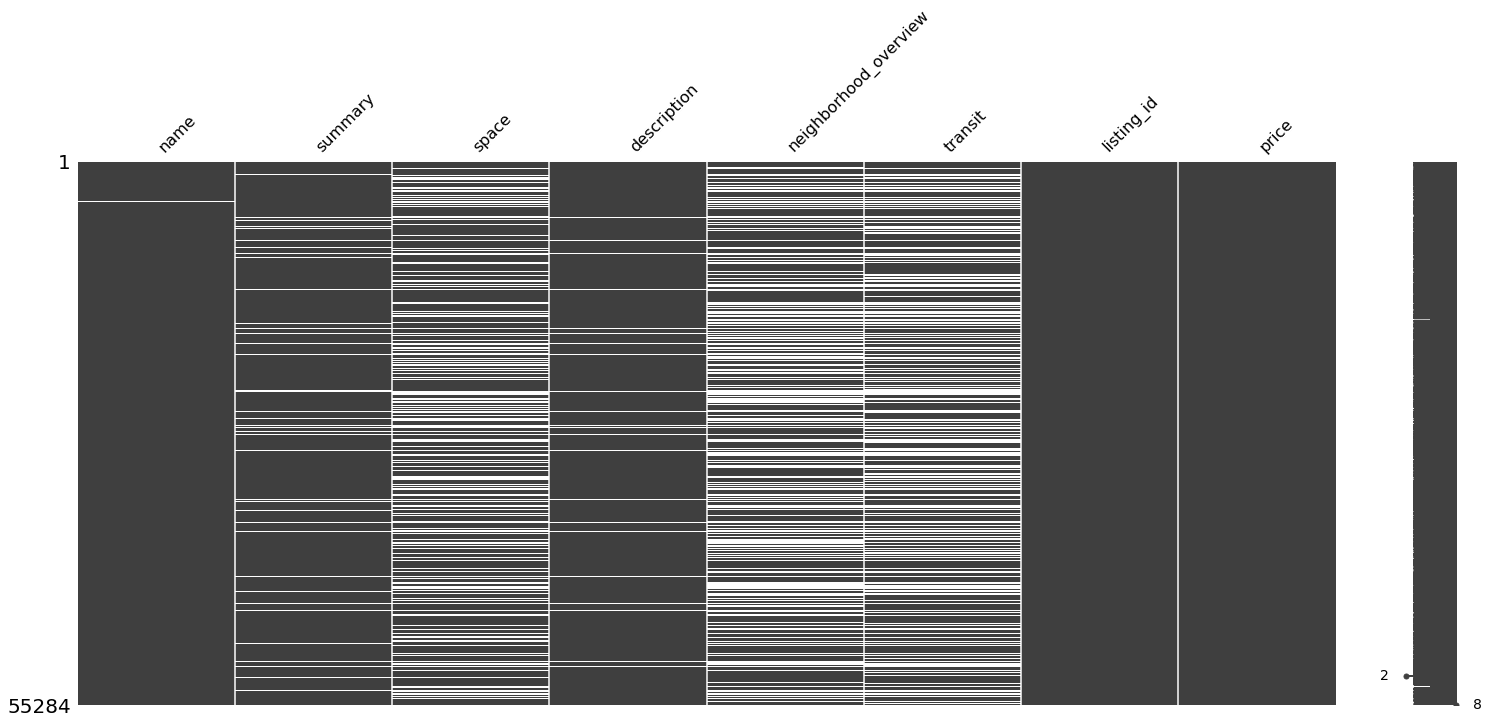

In [10]:
msno.matrix(train_textual)

In [11]:
percentage_empty_train_textual=round(train_textual.isnull().mean() * 100,2)
percentage_empty_train_textual.sort_values(ascending=False)

transit                  35.83
neighborhood_overview    35.28
space                    30.54
summary                   5.34
description               3.12
name                      0.03
listing_id                0.00
price                     0.00
dtype: float64

As over 35% of data are missing both for transit and neighboorhood_overview these textual features will not be used as too much information is missing. Moreover, part of the transit and neighboorhood_overview information will also be incorporated into the categorical feature neighboorhood and the feature review_scores_location. 

The feature description is a concatenation of the features summary, space plus optionally some additional information. 

There are two options for processing those features later on in a model.

One could process the summary and space separately and edit the description to not incorporate information present in the space or summary. However, the feature space is missing in 30% of the training data. Therefore using space alone might not be a good approach in terms of data quality. Furthermore, even if the space feature is missing further information (in addition to the summary) can still be present in the description. 
Hence, the description will be used as a whole but to remedy the vanishing/exploding gradient problem the feature will be truncated to a certain number of words at the end. A truncation at the end is chosen because based on observing many descriptions, often the least important information is written at the end of the description such as "The keys are under the stone." or "It is the third door on the right."

The name of the listing will be treated as a separate textual feature. From a business understanding, the name is shown on the first impression when browsing the Airbnb website. Based on the histogram below the vast majority of names are no longer than 50 words. However, there are 515 outliers which will be truncated to 50 words.

All summaries except 876 are 500 words or below. Whereas over 50% are between 300 and 500 words. The summary usually contains more important information than the following parts of the description. Therefore, the idea is to incorporate as much as possible summary information into the model and rather truncate the further description. For listings having smaller summaries more information for the following parts of the descriptions will be used to also incorporate information from these listings.

Therefore, the following preprocessing of textual data is only done on the name and description column.

In [7]:
length_description=train['description'].str.len()

<AxesSubplot:>

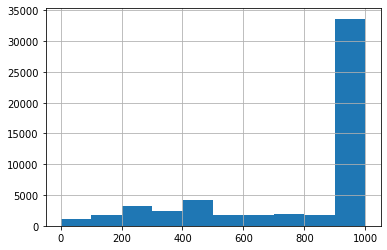

In [8]:
length_description.hist()

In [9]:
length_title=train['name'].str.len()

In [10]:
sum(length_title>50)

515

<AxesSubplot:>

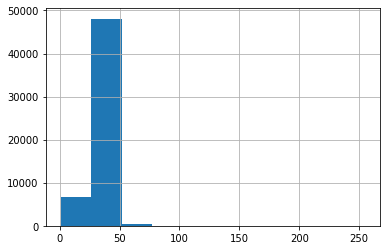

In [11]:
length_title.hist()

It has been checked that all listings are indeed in English. Non relevant columns are deleted.

In [12]:
train_textual = train_textual.drop(['summary', 'space','neighborhood_overview', 'transit'], axis=1)
train_textual = train_textual.set_index('listing_id')

test_textual = test_textual.drop(['summary', 'space','neighborhood_overview', 'transit'], axis=1)
test_textual = test_textual.set_index('listing_id')

Now preprocessing for later encoding the text into Glove embeddings is carried out. Each type of embedding and use case requires there own way of preprocessing. Often, the preprocessing is done by simple regular expressions e.g. removing numbers, lower casing everything etc. However, for Glove this might not be a good idea as the used Glove model is cased and incorporates e.g. many common numbers. It thus, might make a difference for the price of an apartment whether there are 2 balconies or 1 balcony mentioned in the description. 

The way of preprocessing for Glove and the code for the method are inspired by https://www.kaggle.com/code/christofhenkel/how-to-preprocessing-for-glove-part1-eda/notebook. He is an expert in Deep Learning and part of the official NVIDIA Kaggle team https://www.nvidia.com/de-de/ai-data-science/kaggle-grandmasters/. The code and method has been adjusted to fit this use case.

The glove embeddings are loaded from a pickle.

In [13]:
def load_embeddings(path):
    with open(path,'rb') as f:
        emb_arr = pickle.load(f)
    return emb_arr

In [14]:
glove_embeddings = load_embeddings('glove.840B.300d.pkl\glove.840B.300d.pkl')
print(f'loaded {len(glove_embeddings)} word vectors')

loaded 2196008 word vectors


This method checks how many percent of vocabulary from the text is covered with Glove embeddings and how much of the total text is therefore represented by a Glove embedding.
The oov returns words where no Glove embeddings could be found. The idea is to iteratively look at these words and find and correct common patterns so that more Glove embeddings can be found.

In [15]:
def check_coverage(vocab,embeddings_index):
    a = {}
    oov = {}
    k = 0
    i = 0
    for word in tqdm(vocab):
        try:
            a[word] = embeddings_index[word]
            k += vocab[word]
        except:

            oov[word] = vocab[word]
            i += vocab[word]
            pass

    print('Found embeddings for {:.2%} of vocab'.format(len(a) / len(vocab)))
    print('Found embeddings for  {:.2%} of all text'.format(k / (k + i)))
    sorted_x = sorted(oov.items(), key=operator.itemgetter(1))[::-1]
    return sorted_x

def build_vocab(sentences, verbose =  True):
    vocab = {}
    for sentence in tqdm(sentences, disable = (not verbose)):
        for word in sentence:
            try:
                vocab[word] += 1
            except KeyError:
                vocab[word] = 1
    return vocab

In [16]:
train_textual['description'] = train_textual['description'].astype(str)
train_textual['name'] = train_textual['name'].astype(str)

test_textual['description'] = test_textual['description'].astype(str)
test_textual['name'] = test_textual['name'].astype(str)

In [17]:
vocab = build_vocab(list(train_textual['description'].apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:20]

100%|██████████| 126493/126493 [00:00<00:00, 951273.74it/s]

Found embeddings for 36.63% of vocab
Found embeddings for  90.70% of all text


[('kitchen,', 7475),
 ('room,', 6646),
 ('bed,', 6598),
 ('London,', 6441),
 ('restaurants,', 6156),
 ('shops,', 5194),
 ('bathroom,', 3833),
 ('area,', 3785),
 ('bedroom,', 3744),
 ('station,', 3475),
 ('Park,', 3267),
 ('Airbnb)', 3259),
 ('bars,', 3191),
 ('bedrooms,', 2985),
 ("London's", 2973),
 ('TV,', 2754),
 ('flat,', 2752),
 ('cafes,', 2625),
 ('microwave,', 2588),
 ('machine,', 2507)]

Many embeddings could not be discovered due to punctuation errors of some kind. Therefore those characters are replaced with the same characters but with a space added. Punctuation is not removed fully as it can incorporate important information and Glove is able to process it.

In [18]:
def string_replace(string):
    string = string.str.replace(".", " . ")
    string = string.str.replace(". . . ", " . ")
    string = string.str.replace("(", " ( ")
    string = string.str.replace(")", " ) ")
    string = string.str.replace("!", " ! ")
    string = string.str.replace("’", " ' ")
    string = string.str.replace(",", " , ")
    string = string.str.replace(":", " : ")
    string = string.str.replace("£", " £ ")
    return string

In [19]:
train_textual['description'] = string_replace(train_textual['description'])
train_textual['name'] = string_replace(train_textual['name'])
test_textual['description'] = string_replace(test_textual['description'])
test_textual['name'] = string_replace(test_textual['name'])

C:\Users\AppData\Local\Temp\ipykernel_29152\1376409677.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  string = string.str.replace(".", " . ")
C:\Users\AppData\Local\Temp\ipykernel_29152\1376409677.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  string = string.str.replace(". . . ", " . ")
C:\Users\AppData\Local\Temp\ipykernel_29152\1376409677.py:4: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  string = string.str.replace("(", " ( ")
C:\Users\AppData\Local\Temp\ipykernel_29152\1376409677.py:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character reg

Whether to remove or not remove stopwords for Glove is a highly controversial topic with conflicting opinions. Stop words could have substantial meaning for a sentence and are retained by Glove. The Glove authors themself report improved performance when not removing stopwords a priori. On the other hand, for the specific task at hand, the input sequence of interest per listing is longer than what e.g. an LSTM framework could reasonably handle. Therefore if stopwords are removed more valuable information from the description column can be incorporated. It is assumed that this outweighs the potential minor loss in accuracy due to stopword removal. 

Sources: https://aclanthology.org/P12-1092.pdf, https://www.modelop.com/blog/when-not-to-lemmatize-or-remove-stop-words-in-text-preprocessing/ and https://stats.stackexchange.com/questions/201372/the-effect-of-stopword-filtering-prior-to-word-embedding-training

In [20]:
stop = set(stopwords.words('english'))

In [21]:
def stopword_removal(text):
    text = text.apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
    return text

In [22]:
train_textual['description'] = stopword_removal(train_textual['description'])
train_textual['name'] = stopword_removal(train_textual['name'])
test_textual['description'] = stopword_removal(test_textual['description'])
test_textual['name'] = stopword_removal(test_textual['name'])

In [23]:
vocab = build_vocab(list(train_textual['description'].apply(lambda x:x.split())))
oov = check_coverage(vocab,glove_embeddings)
oov[:20]

100%|██████████| 78954/78954 [00:00<00:00, 986931.82it/s]

Found embeddings for 61.31% of vocab
Found embeddings for  98.60% of all text


[("London's", 3002),
 ("You'll", 1312),
 ("There's", 1203),
 ("King's", 1131),
 ('Hotel-quality', 961),
 ("Regent's", 737),
 ("there's", 643),
 ("stone's", 564),
 ("We're", 559),
 ("minutes'", 436),
 ("Sainsbury's", 434),
 ("we're", 360),
 ("Paul's", 329),
 ("Queen's", 317),
 ("Shepherd's", 302),
 ('n-', 297),
 ("children's", 276),
 ('100%', 262),
 ("Earl's", 261),
 ("cafe's", 248)]

Looking at the results the percentage of vocab with embeddings has increased by 25% with some simple preprocessing.

Because the nltk stopword removal list contains the respective words with ' (e.g. aren't) they are preprocessed after stopword removal to fit to Glove.

In [24]:
tokenizer = TreebankWordTokenizer()
def handle_contractions(x):
    x = tokenizer.tokenize(x)
    x = ' '.join(x)
    return x

In [25]:
tqdm.pandas()
train_textual['description'] = train_textual['description'].progress_apply(lambda x:handle_contractions(x))
train_textual['name'] = train_textual['name'].progress_apply(lambda x:handle_contractions(x))
test_textual['description'] = test_textual['description'].progress_apply(lambda x:handle_contractions(x))
test_textual['name'] = test_textual['name'].progress_apply(lambda x:handle_contractions(x))

100%|██████████| 29769/29769 [00:01<00:00, 22811.51it/s]


In [26]:
vocab = build_vocab(list(train_textual['description'].apply(lambda x:x.split())),verbose=False)
oov = check_coverage(vocab,glove_embeddings)
oov[:20]

100%|██████████| 74160/74160 [00:00<00:00, 987920.03it/s]

Found embeddings for 65.67% of vocab
Found embeddings for  99.13% of all text


[('Hotel-quality', 961),
 ('n-', 297),
 ('//www', 229),
 ('-24/7', 169),
 ('neighbourhoo', 163),
 ('doorste', 151),
 ('kitchen/', 149),
 ('Hotel-standard', 131),
 ('500+', 130),
 ('-The', 124),
 ('‘home', 123),
 ('w/', 114),
 ('￫', 96),
 ('Shoreditc', 95),
 ('5*', 91),
 ('-Double', 84),
 ('*Please', 78),
 ('Kensingto', 77),
 ('*FREE', 76),
 ('Hackne', 75)]

These are great results. Now for every 100 words present in the data only 1 has no corresponding embedding. One could of course fine-tune the result further manually. However, given the minimal gain and high time effort this is not considered. Now the data is split into training and testing.

In [27]:
train_textual.to_csv('train_textual.csv', index = True)
test_textual.to_csv('test_textual.csv', index = True)

The non textual data is read from disk and both data sets are merged on the id column.

In [28]:
train_non_textual = pd.read_csv("train_non_textual.csv", sep=",", encoding="utf-8")
test_non_textual = pd.read_csv("test_non_textual.csv", sep=",", encoding="utf-8")

In [29]:
train_non_textual.drop(['price'], axis=1, inplace=True)

In [30]:
train_textual = pd.merge(train_textual, train_non_textual, on='listing_id')
test_textual = pd.merge(test_textual, test_non_textual, on='listing_id')

In [31]:
train_textual = train_textual.set_index('listing_id')
test_textual = test_textual.set_index('listing_id')

In [32]:
X_train, X_test, y_train, y_test = train_test_split(train_textual.loc[: , train_textual.columns != 'price'], train_textual['price'], test_size=0.1)

In [33]:
# max_features = The maximum number of words to keep, based on word frequency. Here different maximum number of words have been tried to test whether limiting the tokenizer to the most e.g. 40.000 frequent words improves predictions.
# This is not the case as it decreases accuracy.
max_features = 400000
tokenizer = Tokenizer(num_words = max_features, filters=' ',lower=False, oov_token='<unw>')

In [34]:
# The tokenizer is fitted on the whole training set as it uses the hugest possible vocabulary
tokenizer.fit_on_texts(train_textual['description'].values + train_textual['name'].values)

Now the training set, the "internal" test set and the "global" test set are tokenized and the sequences are padded to 500 words.

In [35]:
tokenize_text_train_description = tokenizer.texts_to_sequences(X_train.description.values)
pad_text_train_description  = pad_sequences(tokenize_text_train_description, 500, dtype='float64')
tokenize_text_train_name = tokenizer.texts_to_sequences(X_train.name.values)
pad_text_train_name = pad_sequences(tokenize_text_train_name, 50)

In [36]:
tokenize_text_test_description = tokenizer.texts_to_sequences(X_test.description.values)
pad_text_test_description  = pad_sequences(tokenize_text_test_description, 500, dtype='float64')
tokenize_text_test_name = tokenizer.texts_to_sequences(X_test.name.values)
pad_text_test_name = pad_sequences(tokenize_text_test_name, 50)

In [37]:
test_tokenize_text_test_description = tokenizer.texts_to_sequences(test_textual.description.values)
test_pad_text_test_description  = pad_sequences(test_tokenize_text_test_description, 500, dtype='float64')
test_tokenize_text_test_name = tokenizer.texts_to_sequences(test_textual.name.values)
test_pad_text_test_name = pad_sequences(test_tokenize_text_test_name, 50)

In [38]:
embeddings_index = glove_embeddings
word=embeddings_index.keys()
print('Found %s word vectors.' % len(embeddings_index))

Found 2196008 word vectors.


In [39]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 110211 unique tokens.


Creating and filling up the embedding matrix with all tokenized words.

In [40]:
number_words = min(max_features, len(word_index)) + 1
print(number_words)

embedding_dimension = 300
#Embedding matrix is created with zero
embedding_matrix = np.zeros((number_words, embedding_dimension))

# try to find each word from the tokenizer in the glove.embeddings
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    #add word vector to matrix or else initalise the word with a random vector. 
    #This leads to better results than just assigning every oov word the same value.
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
    else:
        embedding_matrix[i] = np.random.randn(embedding_dimension)

110212


# 5. Models on Textual Features

### LSTM

Now different LSTM models are defined and fitted. Several configurations have been systematically tried out but are for brevity not included. The following parameters have been tried out for optimization:
- The input_length
- Different numbers of maximum unique tokens. It turns out that encoding all unique tokens with Glove improves performance.
- Number of neurons in the hidden layer for both features
- Adding different approaches of dropout with various dropout rates without a significant improvement
- Varying batch sizes both bigger and smaller
- Different loss functions such as MSE. Other loss functions than LogCosh() tend to overfit way faster.
- Different epoch numbers. However, through EarlyStopping overfitting is avoided anyway.
- StandardScaling of the target feature prices surprisingly leads to very bad results and very fast overfitting.

The LSTM model has an input shape of 500 for the description and 50 for the listing name. It has one hidden layer with 300 neurons each and one dense layer for each textual feature.

In [30]:
input_description = Input(shape=(500, ))
input_name = Input(shape=(50, ))

# Description
description_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=500, trainable=True)(input_description)
LSTM_description = LSTM(300, return_sequences=False)(description_embeddings)
dense_description = Dense(1, activation="linear") (LSTM_description)

# Name
name_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=50, trainable=True)(input_name)
LSTM_name = LSTM(300, return_sequences=False)(name_embeddings)
dense_name = Dense(1, activation="linear")(LSTM_name)

# Concatenate
output_layer = concatenate([dense_name, dense_description])

model = Model(inputs=[input_description, input_name], outputs=output_layer)
model.compile(loss=losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
model_LSTM = model.fit([pad_text_train_description, pad_text_train_name], y_train, validation_split=0.1, epochs=25, verbose=1, batch_size=128, callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_2 (Embedding)        (None, 50, 300)      33063600    ['input_6[0][0]']                
                                                                                                  
 embedding_1 (Embedding)        (None, 500, 300)     33063600    ['input_5[0][0]']                
                                                                                              

In [33]:
preds = pd.DataFrame(model.predict([pad_text_test_description, pad_text_test_name]), columns=["name_pred", "description_pred"], index=y_test.index)

173/173 [==============================] - 4s 18ms/step


In [35]:
preds["actual"] = y_test

In [36]:
print(f"Text MSE: {mean_squared_error(preds.description_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.description_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.name_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.name_pred, preds.actual)}\n")

Text MSE: 3846.6331436857367
Text MAE: 37.61647850541315

Title MSE: 4177.445691806457
Title MAE: 38.628902394596075



Calculating a RMSE score of (62.01) for the text it can be seen that both features do incorporate substantial meaning for the price prediction, which the model can pick up and which leads to far better prediction than predicting the average price. Nevertheless, even the simple linear regression on non-textual features outperforms this model on textual features.
Hence, a combination of both types of features might be promising.

### Bidirectional LSTM

In [38]:
input_description = Input(shape=(500, ))
input_name = Input(shape=(50, ))

# Description
description_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=500, trainable=True)(input_description)
BILSTM_description = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(description_embeddings)
dense_description = Dense(1, activation="relu") (BILSTM_description)

# Name
name_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=50, trainable=True)(input_name)
BILSTM_name = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(name_embeddings)
dense_name = Dense(1, activation="relu")(BILSTM_name)

# Concatenate
output_layer = concatenate([dense_name, dense_description])

model_BILSTM_1 = Model(inputs=[input_description, input_name], outputs=output_layer)
model_BILSTM_1.compile(loss=losses.LogCosh(), optimizer="adam", metrics=['mae', 'mse'])

print(model_BILSTM_1.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
model_BILSTM = model_BILSTM_1.fit([pad_text_train_description, pad_text_train_name], y_train, validation_split=0.1, epochs=25, verbose=1, batch_size=128, callbacks=callbacks)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_9 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 50, 300)      33063600    ['input_10[0][0]']               
                                                                                                  
 embedding_5 (Embedding)        (None, 500, 300)     33063600    ['input_9[0][0]']                
                                                                                            

In [44]:
preds = pd.DataFrame(model_BILSTM_1.predict([pad_text_test_description, pad_text_test_name]), columns=["name_pred", "description_pred"], index=y_test.index)
preds["actual"] = y_test

173/173 [==============================] - 7s 33ms/step


In [46]:
print(f"Text MSE: {mean_squared_error(preds.description_pred, preds.actual)}")
print(f"Text MAE: {mean_absolute_error(preds.description_pred, preds.actual)}\n") 
print(f"Title MSE: {mean_squared_error(preds.name_pred, preds.actual)}")
print(f"Title MAE: {mean_absolute_error(preds.name_pred, preds.actual)}\n")

Text MSE: 3543.21988532617
Text MAE: 35.92794694174347

Title MSE: 3965.013455883144
Title MAE: 37.679413343385754



The more advanced bidirectional LSTM model performs slightly better as it can incorporate information more sophisticated and probably can get more context out of the text data.

A stacked LSTM has been tried out as well with numerous two hidden layer configurations for each textual feature. However, it performed worse than the bidirectional LSTM. Hence, for readibility, it is not included in the notebook.

# 6. Combining models

Now a strategy for combining textual and non-textual data is necessary. 
A total of four composite strategies will be tested out. The best strategy will be used to train a final model.


1) Usage of both textual features and all non-text textual features that have been used for the baseline models. The textual features are used in the model as shown above in the textual model section. The non-textual features are incorporated into the model by combining the outputs of the textual features through several dense layers. 


2) Usage of the most relevant features (by number of times a feature is used for splitting) from the baseline model. Therefore the baseline model is used to select the most relevant features. A similar idea is represented in this paper https://www.researchgate.net/publication/338950686_Stock_prediction_based_on_random_forest_and_LSTM_neural_network which shows that feature selection through Random Forest + LSTM leads to better predictions than PCA + LSTM.


3) Using the predictions of the best baseline model in combination with the textual features and combining them through multiple dense layers.

4) Using the predictions of the best baseline model in combination with the textual features and combining them through one dense layers with linear activation.

The Bidirectional LSTM model is used as it outperforms the other LSTM models.

### 1. Strategy

In [41]:
input_description = Input(shape=(500, ))
input_name = Input(shape=(50, ))
input_non_textual = Input(shape=(62,))

# Description
description_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=500, trainable=True)(input_description)
BILSTM_description = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(description_embeddings)
dense_description = Dense(1, activation="relu") (BILSTM_description)

# Name
name_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=50, trainable=True)(input_name)
BILSTM_name = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(name_embeddings)
dense_name = Dense(1, activation="relu")(BILSTM_name)

# Concatenate
first_concatination = concatenate([dense_name, dense_description, input_non_textual])
dense_full = Dense(1024, activation="relu")(first_concatination)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

model_final = Model(inputs=[input_description, input_name, input_non_textual], outputs=output_layer)
model_final.compile(loss=losses.LogCosh(), optimizer="adam", metrics=['mae', 'mse'])

print(model_final.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
model = model_final.fit([pad_text_train_description, pad_text_train_name, X_train.drop(columns=['description', 'name'])], 
                        y_train, validation_split=0.1, epochs=25, verbose=1, batch_size=128, callbacks=callbacks)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 50, 300)      33063600    ['input_2[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 500, 300)     33063600    ['input_1[0][0]']                
                                                                                              

In [47]:
preds = pd.DataFrame(model_final.predict([pad_text_test_description, pad_text_test_name, X_test.drop(columns=['description', 'name'])]))
print(f"Price RMSE: {mean_squared_error(preds, y_test, squared=False)}")

173/173 [==============================] - 10s 55ms/step
Price RMSE: 50.70920033502639


As seen this model interestingly performs worse than a simple XGB or Random Forest. To test whether this is due too many non-textual features the second strategy is tried out.

## 2. Strategy

In [52]:
input_description = Input(shape=(500, ))
input_name = Input(shape=(50, ))
input_non_textual = Input(shape=(7,))

# Description
description_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=500, trainable=True)(input_description)
BILSTM_description = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(description_embeddings)
dense_description = Dense(1, activation="relu") (BILSTM_description)

# Name
name_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=50, trainable=True)(input_name)
BILSTM_name = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(name_embeddings)
dense_name = Dense(1, activation="relu")(BILSTM_name)

# Concatenate
first_concatination = concatenate([dense_name, dense_description, input_non_textual])
dense_full = Dense(1024, activation="relu")(first_concatination)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

model_final = Model(inputs=[input_description, input_name, input_non_textual], outputs = output_layer)
model_final.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model_final.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
#define a validation set of size 0.1 of the train set and later on test the result on the completely unseen test set
model = model_final.fit([pad_text_train_description, pad_text_train_name, X_train[['accommodates', 'latitude', 'longitude', 'reviews_per_month', 'host_total_listings_count', 'host_since_years','bathrooms']]], 
                        y_train, validation_split=0.1, epochs=25, verbose=1, batch_size=128, callbacks=callbacks)

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_27 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_26 (InputLayer)          [(None, 500)]        0           []                               
                                                                                                  
 embedding_19 (Embedding)       (None, 50, 300)      33063600    ['input_27[0][0]']               
                                                                                                  
 embedding_18 (Embedding)       (None, 500, 300)     33063600    ['input_26[0][0]']               
                                                                                            

It becomes clear that limiting the non-textual features so heavy does not lead to sophisticated results. Hence, this approach is disregared as it does not seem promising.

## 3. Strategy¶

In [51]:
#Renaming due to the conventions of XGB package
X_train_XGB = X_train

regex = re.compile(r"\[|\]|<", re.IGNORECASE)

X_train_XGB.columns = [regex.sub("_", col) if any(x in str(col) for x in set(('[', ']', '<'))) else col for col in X_train.columns.values]

In [52]:
#Using the best params that have been found via GridSearch in the non-textual model section
params = {'max_depth': [10],
           'learning_rate': [0.01],
           'n_estimators': [2200],
           'colsample_bytree': [0.3]}
xgbr = xgb.XGBRegressor(seed=20, tree_method='gpu_hist')  
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=2, cv=3)
clf.fit(X_train_XGB.drop(columns=['description', 'name']), y_train)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time= 1.7min
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time= 1.7min
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time= 1.7min
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 2200}
Lowest RMSE:  45.77811662256834


Getting predictions of the XGB model for the training data. These predicitions will be used in building the Bidirectional LSTM model.

In [53]:
preds = clf.predict(X_train_XGB.drop(columns=['description', 'name']))
X_train = X_train_XGB.assign(prediction = preds)

Getting predictions of the XGB model for the "local" test data. These predicitions will be used while obtaining predictions from the Bidirectional LSTM model.

In [58]:
preds = clf.predict(X_test.drop(columns=['description', 'name']))
X_test = X_test.assign(price = preds)

In [75]:
print(f"Price RMSE: {mean_squared_error(X_test.price, y_test, squared=False)}")

Price RMSE: 46.34944012359759


Getting predictions of the XGB model for the "global" test data. These predicitions will be used while obtaining predictions from the Bidirectional LSTM model.

In [55]:
preds_test = clf.predict(test_textual.drop(columns=['description', 'name']))
test_textual =test_textual.assign(price = preds_test)

In [65]:
input_description = Input(shape=(500, ))
input_name = Input(shape=(50, ))
input_non_textual = Input(shape=(1,))

# Description
description_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=500, trainable=True)(input_description)
BILSTM_description = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(description_embeddings)
dense_description = Dense(1, activation="relu") (BILSTM_description)

# Name
name_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=50, trainable=True)(input_name)
BILSTM_name = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(name_embeddings)
dense_name = Dense(1, activation="relu")(BILSTM_name)

# Concatenate
first_concatination = concatenate([dense_name, dense_description, input_non_textual])
dense_full = Dense(1024, activation="relu")(first_concatination)
dense_full = Dense(512, activation="relu")(dense_full)
dense_full = Dense(256, activation="relu")(dense_full)
output_layer = Dense(1, activation="linear")(dense_full)

model_final = Model(inputs=[input_description, input_name, input_non_textual], outputs = output_layer)
model_final.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model_final.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
model = model_final.fit([pad_text_train_description, pad_text_train_name, X_train['prediction']], 
                        y_train, validation_split=0.1, epochs=25, verbose=1, batch_size=128, callbacks=callbacks)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 50, 300)      33063600    ['input_5[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 500, 300)     33063600    ['input_4[0][0]']                
                                                                                            

Important note: 
The train and validation losses need to be taken with a grain of salt for this model because the XGB results are taken as one input for the Bidirectional LSTM model. However, the XGB model is trained with the data that is also incorporated into the LSTM model for training. Hence, it is expected that training might overfit quickly and that performance can be significantly different than on the "global" test data. Therefore, this model needs to be tested on the "global" test data to get reliable information on model accuracy.

In [67]:
preds = pd.DataFrame(model_final.predict([pad_text_test_description, pad_text_test_name, X_test.price]))
print(f"Price RMSE: {mean_squared_error(preds, y_test, squared=False)}")

173/173 [==============================] - 6s 34ms/step
Price RMSE: 46.16046652613718


In [ ]:
#Getting the predictions for Kaggle
kaggle_predictions = pd.DataFrame(model_final.predict([test_pad_text_test_description, test_pad_text_test_name, test_textual.price]), columns=["price"], index=test_textual.index)
kaggle_predictions

kaggle_predictions['listing_id'] = kaggle_predictions.index
submission = kaggle_predictions[['listing_id', 'price']]

submission.to_csv('submission4.csv', index = False)
submission.head()

As shown incorporating the textual data on top of the XGB model slighly lowers the RMSE by 0.19. Interestingly, the method works even better when performing it on the "global" test data. As it scores an RMSE of 44.56 on Kaggle.

Additionally, it has been tried out to combine the textual features and the predicitions of the XGB model with just one dense layer in a linear regression format. This does lead to even better results with another improvement of 0.4 on the Kaggle RMSE score to 44.16.

## 4. Strategy¶

In [77]:
input_description = Input(shape=(500, ))
input_name = Input(shape=(50, ))
input_non_textual = Input(shape=(1,))

# Description
description_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=500, trainable=True)(input_description)
BILSTM_description = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(description_embeddings)
dense_description = Dense(1, activation="relu") (BILSTM_description)

# Name
name_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=50, trainable=True)(input_name)
BILSTM_name = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(name_embeddings)
dense_name = Dense(1, activation="relu")(BILSTM_name)

# Concatenate
first_concatination = concatenate([dense_name, dense_description, input_non_textual])
output_layer = Dense(1, activation="linear")(first_concatination)

model_final_linear = Model(inputs=[input_description, input_name, input_non_textual], outputs = output_layer)
model_final_linear.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model_final_linear.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
model = model_final_linear.fit([pad_text_train_description, pad_text_train_name, X_train['prediction']], 
                        y_train, validation_split=0.1, epochs=25, verbose=1, batch_size=128, callbacks=callbacks)

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 input_7 (InputLayer)           [(None, 500)]        0           []                               
                                                                                                  
 embedding_5 (Embedding)        (None, 50, 300)      33063600    ['input_8[0][0]']                
                                                                                                  
 embedding_4 (Embedding)        (None, 500, 300)     33063600    ['input_7[0][0]']                
                                                                                            

In [78]:
preds_linear = pd.DataFrame(model_final_linear.predict([pad_text_test_description, pad_text_test_name, X_test.price]))
print(f"Price RMSE: {mean_squared_error(preds3, y_test, squared=False)}")

173/173 [==============================] - 9s 43ms/step
Price RMSE: 45.719142538583476


In [79]:
#Getting the predictions for Kaggle
kaggle_predictions = pd.DataFrame(model_final_linear.predict([test_pad_text_test_description, test_pad_text_test_name, test_textual.price]), columns=["price"], index=test_textual.index)
kaggle_predictions
kaggle_predictions['listing_id'] = kaggle_predictions.index
submission = kaggle_predictions[['listing_id', 'price']]

submission.to_csv('submission5.csv', index = False)
submission.head()

931/931 [==============================] - 34s 36ms/step


,listing_id,price
listing_id,,
0FEMC4VA5U,0FEMC4VA5U,103.007111
PQ2BYEO0QR,PQ2BYEO0QR,122.714500
3FP6WFHUBN,3FP6WFHUBN,102.239166
GG0V2KDG90,GG0V2KDG90,41.456512
TZVVK4YSIO,TZVVK4YSIO,101.871162


To conclude, the final model architecture looks like this:

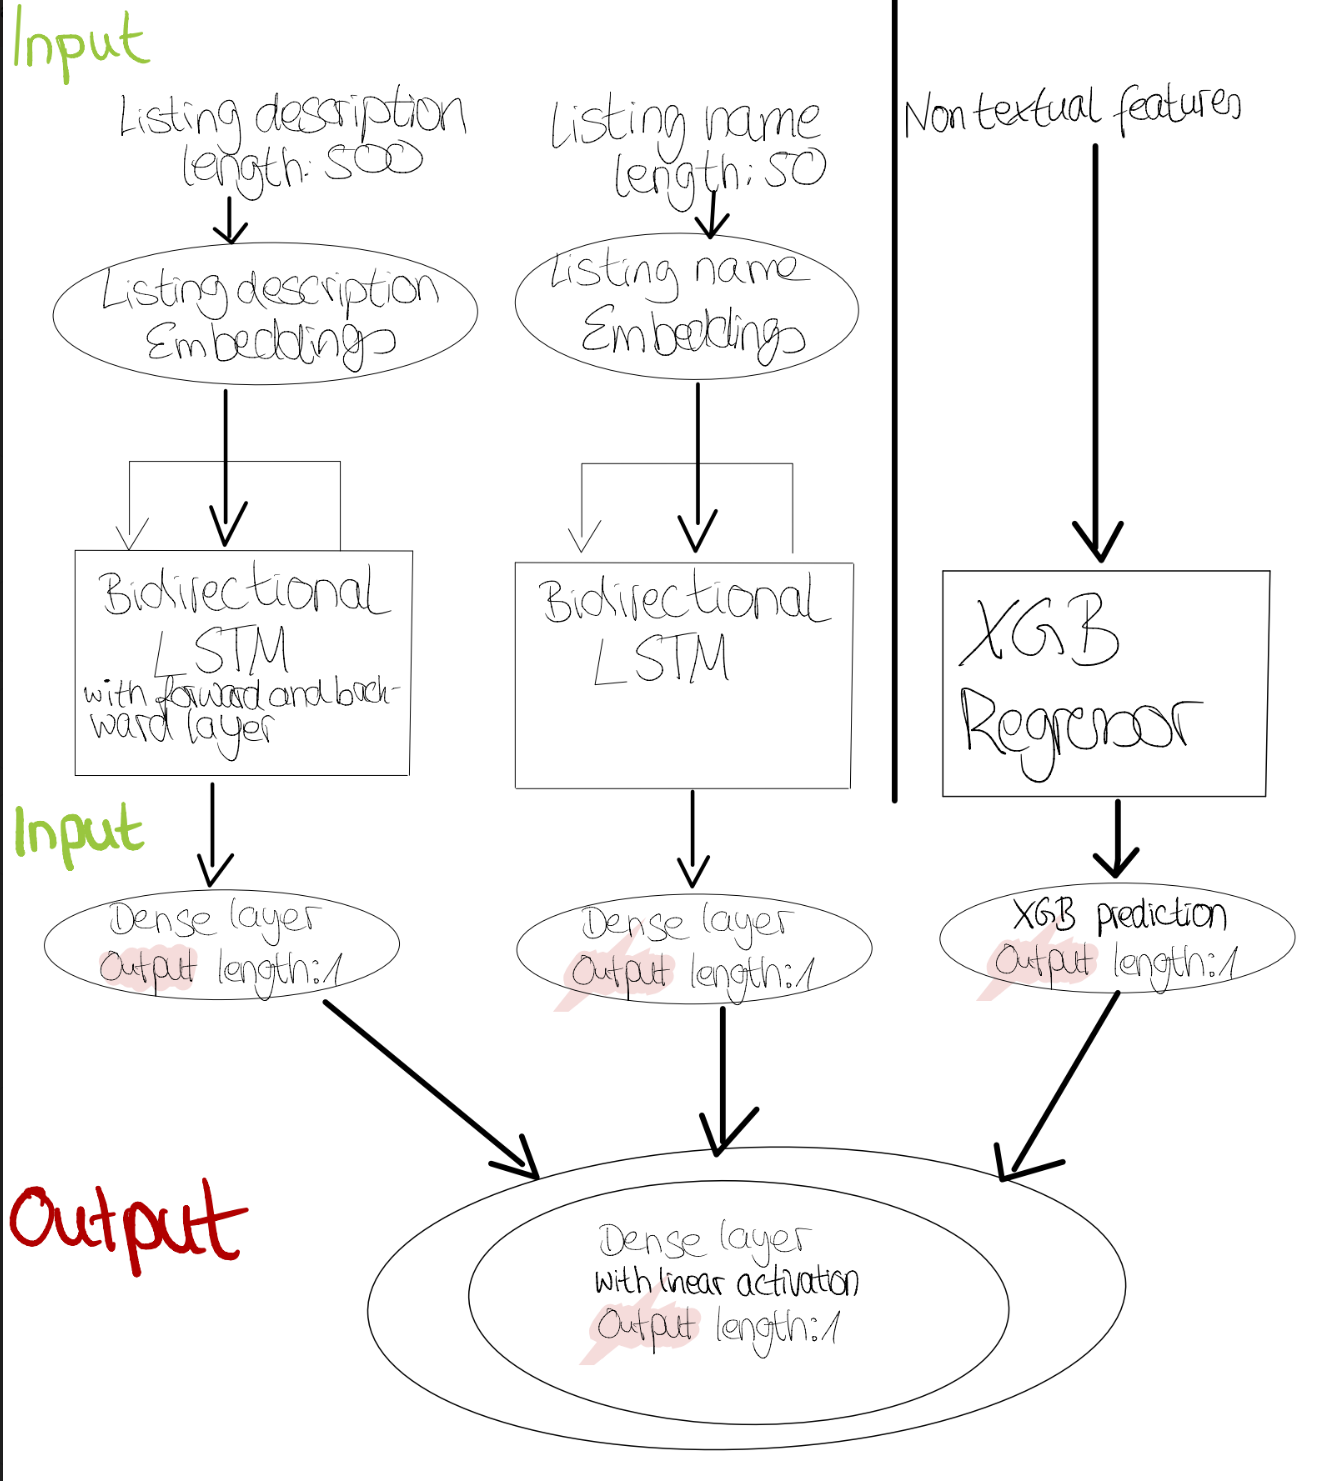

In [255]:
Image("Network_drawing.png", width=600)

# 7. Application to the Test Set Using the whole Training Set

In [103]:
#Renaming for merging
X_test.rename(columns={'host_response_rate_90<x<=99' : 'host_response_rate_90_x_=99', 'review_scores_rating_95<x<=99': 'review_scores_rating_95_x_=99', 'review_scores_rating_90<x<=95' : 'review_scores_rating_90_x_=95'}, inplace=True)

In [90]:
#Dropping the columns that have been inserted through the previous training
X_train = X_train.drop(columns = ['prediction'])
X_test = X_test.drop(columns = ['price'])
test_textual = test_textual.drop(columns = ['price'])

In [105]:
df = X_train.append(X_test)

C:\Users\AppData\Local\Temp\ipykernel_29152\2917575911.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = X_train.append(X_test)


In [109]:
y = y_train.append(y_test)

C:\Users\AppData\Local\Temp\ipykernel_29152\3621025881.py:1: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  y = y_train.append(y_test)


In [111]:
#Using the best params that have been found via GridSearch in the non-textual model section
params = {'max_depth': [10],
           'learning_rate': [0.01],
           'n_estimators': [2200],
           'colsample_bytree': [0.3]}
xgbr = xgb.XGBRegressor(seed = 20, tree_method='gpu_hist')  
clf = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=2, cv=3)
clf.fit(df.drop(columns=['description', 'name']), y)
print("Best parameters:", clf.best_params_)
print("Lowest RMSE: ", (-clf.best_score_)**(1/2.0))

Fitting 3 folds for each of 1 candidates, totalling 3 fits
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time= 1.7min
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time= 1.7min
[CV] END colsample_bytree=0.3, learning_rate=0.01, max_depth=10, n_estimators=2200; total time= 1.7min
Best parameters: {'colsample_bytree': 0.3, 'learning_rate': 0.01, 'max_depth': 10, 'n_estimators': 2200}
Lowest RMSE:  45.789091894817126


Getting predictions of the XGB model for the training data. These predicitions will be used in building the Bidirectional LSTM model.

In [113]:
preds = clf.predict(df.drop(columns=['description', 'name']))
df = df.assign(prediction = preds)

Getting predictions of the XGB model for the "global" test data. These predicitions will be used while obtaining predictions from the Bidirectional LSTM model.

In [117]:
preds_test = clf.predict(test_textual.drop(columns=['description', 'name']))
test_textual =test_textual.assign(price = preds_test)

In [125]:
# Concatenating the padded description and name again
df_pad_text_train_description = np.concatenate((pad_text_train_description, pad_text_test_description))
df_pad_text_train_name = np.concatenate((pad_text_train_name, pad_text_test_name))

In [129]:
input_description = Input(shape=(500, ))
input_name = Input(shape=(50, ))
input_non_textual = Input(shape=(1,))

# Description
description_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=500, trainable=True)(input_description)
BILSTM_description = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(description_embeddings)
dense_description = Dense(1, activation="relu") (BILSTM_description)

# Name
name_embeddings = Embedding(number_words, output_dim=300,
                     embeddings_initializer=Constant(embedding_matrix),
                     input_length=50, trainable=True)(input_name)
BILSTM_name = Bidirectional(LSTM(300, return_sequences=False), merge_mode="concat")(name_embeddings)
dense_name = Dense(1, activation="relu")(BILSTM_name)

# Concatenate
first_concatination = concatenate([dense_name, dense_description, input_non_textual])
output_layer = Dense(1, activation="linear")(first_concatination)

model_final_linear = Model(inputs=[input_description, input_name, input_non_textual], outputs = output_layer)
model_final_linear.compile(loss = losses.LogCosh(), optimizer = "adam", metrics=['mae', 'mse'])

print(model_final_linear.summary())
callbacks = [EarlyStopping(monitor='val_loss', patience=2, verbose=1, min_delta=0.01, restore_best_weights=True)]
model = model_final_linear.fit([df_pad_text_train_description, df_pad_text_train_name, df['prediction']], 
                        y, validation_split=0.1, epochs=25, verbose=1, batch_size=128, callbacks=callbacks)

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 50)]         0           []                               
                                                                                                  
 input_10 (InputLayer)          [(None, 500)]        0           []                               
                                                                                                  
 embedding_7 (Embedding)        (None, 50, 300)      33063600    ['input_11[0][0]']               
                                                                                                  
 embedding_6 (Embedding)        (None, 500, 300)     33063600    ['input_10[0][0]']               
                                                                                            

In [131]:
#Getting the predictions for Kaggle
kaggle_predictions = pd.DataFrame(model_final_linear.predict([test_pad_text_test_description, test_pad_text_test_name, test_textual.price]), columns=["price"], index=test_textual.index)
kaggle_predictions
kaggle_predictions['listing_id'] = kaggle_predictions.index
submission = kaggle_predictions[['listing_id', 'price']]

submission.to_csv('submission6.csv', index = False)
submission.head()

931/931 [==============================] - 33s 34ms/step


,listing_id,price
listing_id,,
0FEMC4VA5U,0FEMC4VA5U,96.240486
PQ2BYEO0QR,PQ2BYEO0QR,122.808266
3FP6WFHUBN,3FP6WFHUBN,126.110733
GG0V2KDG90,GG0V2KDG90,32.769234
TZVVK4YSIO,TZVVK4YSIO,103.585228


Please note including all training data does not improve the accuracy on the Kaggle test data. Hence, chapter 7. can be viewed as optional.

# 8. Summary

In summary, the notebook shows how textual and non-textual data can be prepared and cleaned for modeling. Different modeling approaches for non-textual features (linear regression, random forest, XGB) have been demonstrated and evaluated. Furthermore, various modeling approaches have been tested for the textual features (LSTM, Bidirectional LSTM, Stacked LSTM). In the end, different modeling approaches have been caried to combine textual and non-textual data with one final model selected.

While the XGB and random forest model performed quite well in the first place already. It has been shown that the textual features indeed carried some predictive power. However, the combination of both types of features has been only decreasing the RMSE slightly by roughly 0.7. Clearly, it is debatable whether such a small improvement for incorporating the textual information is worth the time effort, computational costs, and environmental impact of processing such huge textual models. 

The assumption is that lot of the valuable information within the text data is already present in the non-textual features such neighbourhood, number of bathrooms, extra features etc...

Nevertheless, the assignment has been a great and fun exercise to strengthen my Deep Learning skills. 

Additionally, a Bert Regression model has been trained as it somehow contrasts the reading flow and is NOT important for the final model it is put into the Appendix. However, I do think that the Bert modeling approach is interesting and worth looking at.

# 9. Appendix - Bert Regression and Results

The interest in state of the art NLP is huge. One model that has long dominated the headlines is BERT. Usually, BERT is used in a classification setting. However, for this task, BERT has been used in a regression setting. 

One could have easily used BERT to predict sentiment. However, there is no setting from a business point of view where this makes a lot of sense. 
1) The description text will be rather written neutral or positive as the host of the listing wants to support a booking with it.
2) One could have used the review text to get sentiment out of them. However, in the model very detailed review data is incorporated in a categorical format already. Hence, the additional benefit most probably will be very low. 

Alternatively, it might be promising to train a BERT model on the textual features only in the first place and if successful later on incorporate the non-textual features.
Exactly this approach is tried out. 

Surprisingly, there is VERY little information on how to use BERT in a  regression context. 

Besides the huggingface docu the following training mainly uses these two blog posts as inspiration for method and coding:

https://mccormickml.com/2019/07/22/BERT-fine-tuning/
and https://medium.com/@anthony.galtier/fine-tuning-bert-for-a-regression-task-is-a-description-enough-to-predict-a-propertys-list-price-cf97cd7cb98a which uses the CamemBert model. 

The coding and method have been of course adjusted to fit the specific training data and task.

Within the Bert training process many sacrifices had to be made (length of input, batch size, training rounds, etc..) to make the training somehow visible on the local GPU. 

To get a good impression of how the BERT training went it is enough to just read the comments below. 
I left the code for my proof of work on how I got to write these comments.

In [3]:
train_textual_bert = pd.read_csv("train_textual_bert.csv", sep=",", encoding="utf-8")
test_textual_bert = pd.read_csv("test_textual_bert.csv", sep=",", encoding="utf-8")

When training BERT with more than one textual feature it is most easy to combine the textual feature with a seperator (SEP) command as BERT than is able to handle it.

In [4]:
train_textual_bert['cleaned_description'] = train_textual_bert.name.map(str) + " [SEP] " + train_textual_bert.description

In [5]:
test_textual_bert['cleaned_description'] = test_textual_bert.name.map(str) + " [SEP] " + test_textual_bert.description

In [7]:
train_textual_bert = train_textual_bert.set_index('listing_id')

In [8]:
train_textual_bert.cleaned_description = train_textual_bert.cleaned_description.astype(str)

The BertTokenizer is loaded and the textual input is truncated to 300 words maximum. Otherwise the GPU runs out of memory later on for training.

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
encoded_corpus = tokenizer(text=train_textual_bert.cleaned_description.tolist(),
                            add_special_tokens=True,
                            padding='max_length',
                            truncation='longest_first',
                            max_length=300,
                            return_attention_mask=True)
input_ids = encoded_corpus['input_ids']
attention_mask = encoded_corpus['attention_mask']

In [10]:
input_ids = np.array(input_ids)
attention_mask = np.array(attention_mask)
labels = train_textual_bert.price.to_numpy()

In [11]:
#Create train and internal test data
test_size = 0.1
seed = 42
train_inputs, test_inputs, train_labels, test_labels = \
            train_test_split(input_ids, labels, test_size=test_size, 
                             random_state=seed)
train_masks, test_masks, _, _ = train_test_split(attention_mask, 
                                        labels, test_size=test_size, 
                                        random_state=seed)

Scaling the target variable has been tried out as well but does not lead not improved results.

In [12]:
#Reshaping data to adjust it to the required import format
train_labels = train_labels.reshape(-1, 1)
test_labels = test_labels.reshape(-1, 1)

In [13]:
#Batch size of 15 is the maximum that is feasible for the GPU
batch_size = 15
def create_dataloaders(inputs, masks, labels, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    labels_tensor = torch.tensor(labels).to(torch.float32)
    dataset = TensorDataset(input_tensor, mask_tensor, 
                            labels_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=True)
    return dataloader
train_dataloader = create_dataloaders(train_inputs, train_masks, 
                                      train_labels, batch_size)
test_dataloader = create_dataloaders(test_inputs, test_masks, 
                                     test_labels, batch_size)

In [14]:
#Define the BertModule and forward step
class BertRegressor(nn.Module):
    def __init__(self, drop_rate=0.2):
        
        super(BertRegressor, self).__init__()
        D_in, D_out = 768, 1
        self.bert = \
                   BertModel.from_pretrained('bert-base-uncased')
        self.regressor = nn.Sequential(
            nn.Dropout(drop_rate),
            nn.Linear(D_in, D_out))
    def forward(self, input_ids, attention_masks):
        
        outputs = self.bert(input_ids, attention_masks)
        class_label_output = outputs[1]
        outputs = self.regressor(class_label_output)
        return outputs
model = BertRegressor(drop_rate=0.2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


This warning can be ignored see https://github.com/huggingface/transformers/issues/5421.

In [15]:
#Check GPU availability and use GPU if possible
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print("Using GPU.")
else:
    print("No GPU available, using the CPU instead.")
    device = torch.device("cpu")
model.to(device)

Using GPU.


BertRegressor(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True

In [16]:
#Define the optimizer for the model
optimizer = AdamW(model.parameters(),
                  lr=5e-5,
                  eps=1e-8)

C:\Users\Anaconda3\envs\Adams\lib\site-packages\transformers\optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [17]:
epochs = 10
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,       
                 num_warmup_steps=0, num_training_steps=total_steps)

In [18]:
loss_function =nn.MSELoss()

In [19]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [20]:
# Function to calculate the r2_score of the model
def r2_score(outputs, labels):
    labels_mean = torch.mean(labels)
    ss_tot = torch.sum((labels - labels_mean) ** 2)
    ss_res = torch.sum((labels - outputs) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [22]:
#Method to perform the actual training and evaluate the model afterwards
def train(model, optimizer, scheduler, loss_function, epochs,       
          train_dataloader, device, clip_value=2):
    training_stats = []
    for epoch in range(epochs):
        print(epoch)
        print("-----")
        best_loss = 1e10
        # Reset the total loss for this epoch.
        total_train_loss = 0
        model.train()
        for step, batch in enumerate(train_dataloader):  
            batch_inputs, batch_masks, batch_labels = \
                               tuple(b.to(device) for b in batch)
            model.zero_grad()
            outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs.squeeze(),
                                 batch_labels.squeeze())
            total_train_loss += loss.item()
            loss.backward()
            clip_grad_norm_(model.parameters(), clip_value)
            optimizer.step()
            scheduler.step()
        avg_train_loss = total_train_loss / len(train_dataloader)
        print("")
        print("  Average training loss: {0:.2f}".format(avg_train_loss))

        ##### VALIDATION
        model.eval()
        # Tracking variables 
        r2 = 0
        total_eval_loss = 0
        for batch in test_dataloader:
            batch_inputs, batch_masks, batch_labels = \
                                     tuple(b.to(device) for b in batch)
            with torch.no_grad():
                outputs = model(batch_inputs, batch_masks)
            loss = loss_function(outputs, batch_labels)
            total_eval_loss += loss.item()
            r2 = r2_score(outputs, batch_labels)
        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(test_dataloader)

        # Calculate the average loss over all of the batches.
        avg_val_loss = total_eval_loss / len(test_dataloader)

        print("  Validation Loss: {0:.2f}".format(avg_val_loss))
        
        # Record all statistics from this epoch.
        training_stats.append(
            {
                'epoch': epoch + 1,
                'Training Loss': avg_train_loss,
                'R2': r2,
                'Valid. Loss': avg_val_loss
            }
            )   
    return model,training_stats

model, training_stats = train(model, optimizer, scheduler, loss_function, epochs, 
              train_dataloader, device, clip_value=2)

0
-----

  Average training loss: 12608.24
  Validation Loss: 8613.22
1
-----

  Average training loss: 7867.12
  Validation Loss: 7154.07
2
-----

  Average training loss: 7251.72
  Validation Loss: 7102.14
3
-----

  Average training loss: 7197.03
  Validation Loss: 7081.36
4
-----

  Average training loss: 7191.67
  Validation Loss: 7098.27


In [23]:
df_stats = pd.DataFrame(data=training_stats)
df_stats['R2']=df_stats['R2'].astype(float)

In [24]:
# Use the epoch as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,R2,Valid. Loss
epoch,,,
1,12608.238299,-1.232386,8613.217217
2,7867.115315,-0.032914,7154.069049
3,7251.722283,-0.043383,7102.139057
4,7197.029617,-0.037985,7081.363143
5,7191.665641,-0.263150,7098.266910


As one can see the predictive power of the model is non-existent with a negative R2. The model does not seem to catch up on the incorporated information within the text. 
This might be due to an error within the model (especially about shapes of input and output). However, this option has been tested extensively.

Rather after very long research, the following open bug on the official BERT repo has been found:
https://github.com/google-research/bert/issues/462. People experience the problem that BERT when using it for regression predicts all values within a very small range in this case around 11. This is also true for this model here. The proposed solution was to freeze all layers except the head layers, which worked for some people. This solution has been tested but does not fix the issue in this case here.

Overall, even if the training with BERT has not been successful it has been an interesting experience to use such a large model on a local computer. It might be the case that the parameters used such as batch size are not sufficient for training or that there is a general problem when using BERT with regression as shown in the Github issue.

## Get predictions for unknown test set

In [55]:
test_textual_bert['cleaned_description'] = test_textual_bert['cleaned_description'].astype(str)

In [56]:
def predict(model, dataloader, device):
    model.eval()
    output = []
    for batch in dataloader:
        batch_inputs, batch_masks= \
                                  tuple(b.to(device) for b in batch)
        with torch.no_grad():
            output += model(batch_inputs, 
                            batch_masks).view(1,-1).tolist()[0]
    return output

In [57]:
def create_dataloaders_without_labels(inputs, masks, batch_size):
    input_tensor = torch.tensor(inputs)
    mask_tensor = torch.tensor(masks)
    dataset = TensorDataset(input_tensor, mask_tensor)
    dataloader = DataLoader(dataset, batch_size=batch_size, 
                            shuffle=False)
    return dataloader

In [63]:
val_set = test_textual_bert[['cleaned_description']]
encoded_val_corpus = \
                tokenizer(text=val_set.cleaned_description.tolist(),
                          add_special_tokens=True,
                          padding='max_length',
                          truncation='longest_first',
                          max_length=300,
                          return_attention_mask=True)
val_input_ids = np.array(encoded_val_corpus['input_ids'])
val_attention_mask = np.array(encoded_val_corpus['attention_mask'])


In [64]:
val_dataloader = create_dataloaders_without_labels(val_input_ids, 
                         val_attention_mask, batch_size=15)
y_pred_scaled = predict(model, val_dataloader, device)

In [65]:
y_pred_scaled

[11.579602241516113,
 11.587706565856934,
 11.585450172424316,
 11.581331253051758,
 11.58528995513916,
 11.585455894470215,
 11.587698936462402,
 11.585618019104004,
 11.584617614746094,
 11.587992668151855,
 11.586533546447754,
 11.58673095703125,
 11.586882591247559,
 11.585177421569824,
 11.586690902709961,
 11.58801555633545,
 11.566245079040527,
 11.587632179260254,
 11.585198402404785,
 11.586546897888184,
 11.587174415588379,
 11.582125663757324,
 11.584356307983398,
 11.586013793945312,
 11.587145805358887,
 11.5847806930542,
 11.582664489746094,
 11.581254959106445,
 11.585758209228516,
 11.585535049438477,
 11.587456703186035,
 11.588428497314453,
 11.585737228393555,
 11.588699340820312,
 11.588835716247559,
 11.587569236755371,
 11.585525512695312,
 11.58750057220459,
 11.588444709777832,
 11.584647178649902,
 11.58641242980957,
 11.585678100585938,
 11.574522018432617,
 11.58676528930664,
 11.58090591430664,
 11.587191581726074,
 11.586751937866211,
 11.585074424743652,
 

Overall while BERT has not been successful the part before the appendix demonstrates well how to combine textual and non-textual data and predict an Airbnb price for a London apartment.

Thanks for reading until here! 